# **1) PRE-PROCESSING**

---



In [1]:
%%capture
!pip install tldextract

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import sys
import time

# Graphics Libs
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 18, 8
import seaborn as sns

# Feature extraction Libs
import requests
from urllib.parse import urlparse, urlsplit
import tldextract
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Models and utils
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

# Keras library for autoencoder
from keras.models import Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from keras.utils import plot_model

# Pytorch library for neural network
import torch
from torch import nn, optim
import torch.nn.functional as F
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('Device is: ', str(device).upper())

Device is:  MPS


In [2]:
IS_COLAB = 'google.colab' in sys.modules
if IS_COLAB:
    DATA_PATH = "https://cdn.albertovalerio.com/datasets/malicious_url/malicious_urls.csv"
    DATA_PATH_URL_SAMPLED = "https://cdn.albertovalerio.com/datasets/malicious_url/urls_sampled.csv"
    DATA_PATH_URL_FEATURES = "https://cdn.albertovalerio.com/datasets/malicious_url/urls_with_features.csv"
else:
    DATA_PATH ='datasets/malicious_urls.csv'
    DATA_PATH_URL_SAMPLED = 'datasets/urls_sampled.csv'
    DATA_PATH_URL_FEATURES = 'datasets/urls_with_features.csv'

In [3]:
data = pd.read_csv(DATA_PATH)
data.describe()

,url,type
count,663191,663191
unique,653040,5
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [4]:
# Removing duplicates
data = data.drop_duplicates(subset='url')
data.describe()

,url,type
count,653040,653040
unique,653040,5
top,br-icloud.com.br,benign
freq,1,428080


In [5]:
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
663186,http://archive.salisburyjournal.co.uk/2001/3/7/,spam
663187,http://astore.amazon.co.uk/allezvinsfrenchr/de...,spam
663188,http://archive.thisischeshire.co.uk/2000/1/14/...,spam
663189,http://applerugs.co.uk/rugs/product_info.php?p...,spam


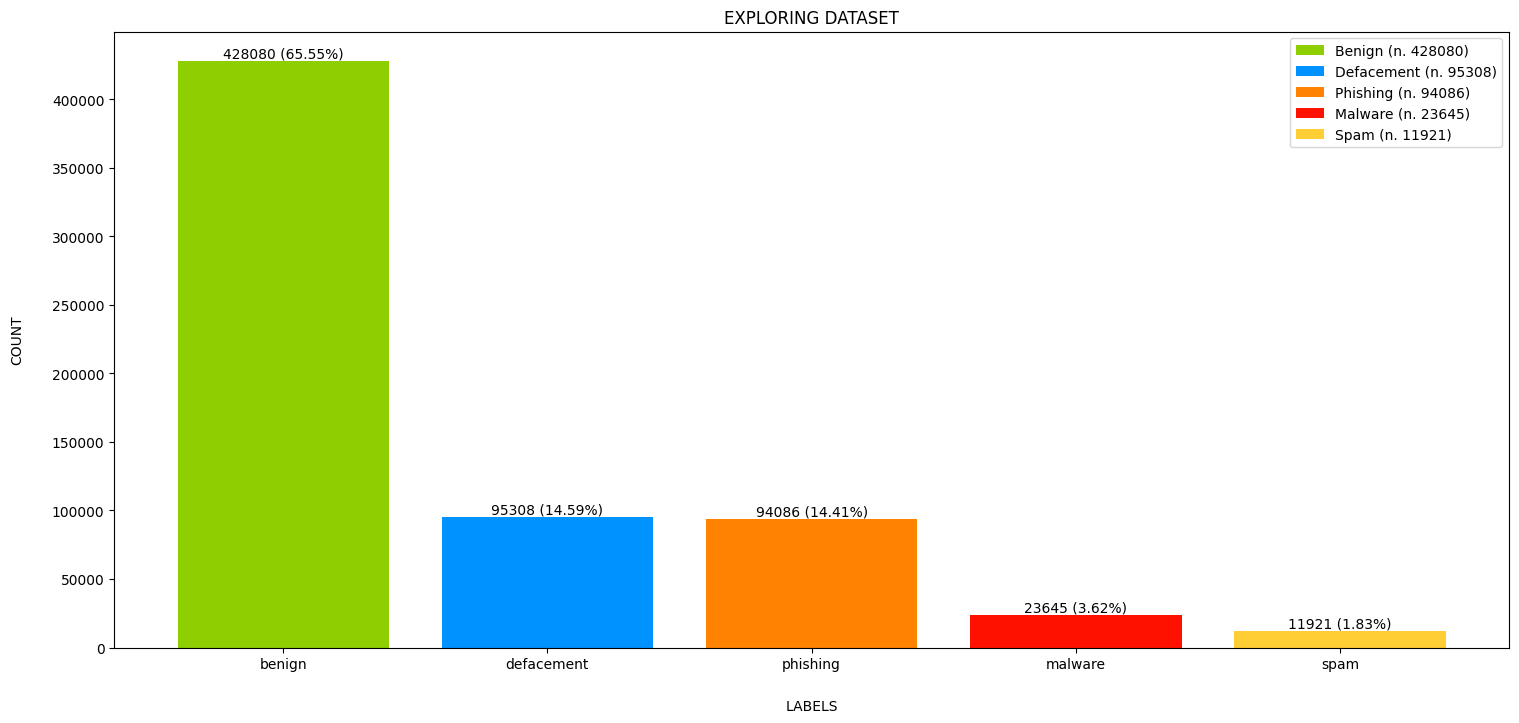

In [6]:
count = data.type.value_counts()
bar_labels = [count.index[i].capitalize()+' (n. ' + str(count[i]) + ')' for i in range(len(count.index))]
bars = plt.bar(count.index, height=count, label=bar_labels, color=['#8fce00', '#0092ff', '#ff8200', '#ff1100', '#ffcd34'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(data)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('LABELS', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.legend()
plt.show()

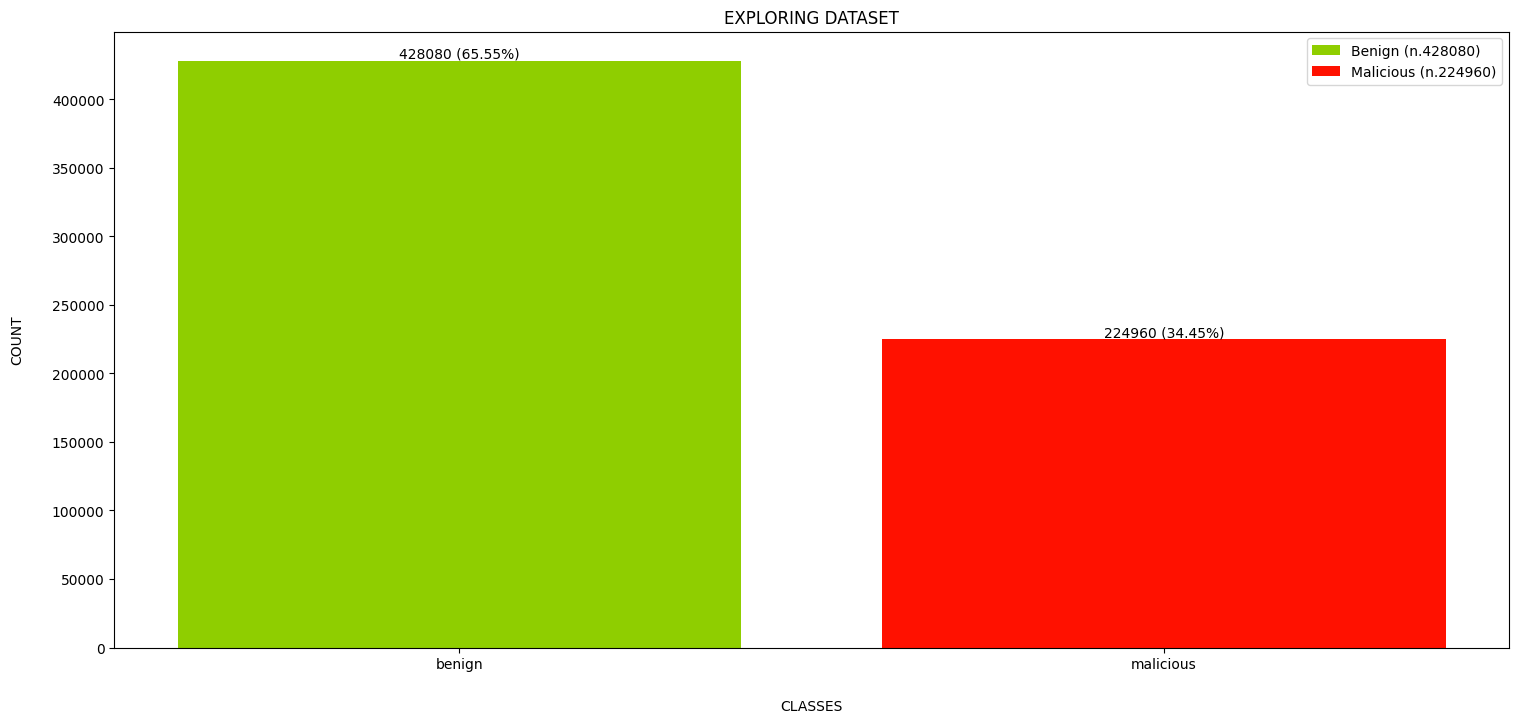

In [7]:
benign = count[0]
malicious = len(data) - benign
bar_labels = ['Benign (n.'+str(benign)+')', 'Malicious (n.'+str(malicious)+')']
bars = plt.bar(['benign', 'malicious'], height=[benign, malicious], label=bar_labels, color=['#8fce00', '#ff1100'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(data)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('CLASSES', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.legend()
plt.show()

In [8]:
benign_urls = data[data['type'] == 'benign']
defacement_urls = data[data['type'] == 'defacement']
phishing_urls = data[data['type'] == 'phishing']
malware_urls = data[data['type'] == 'malware']
spam_urls = data[data['type'] == 'spam']

benign_urls_sample = random.sample(list(benign_urls.index), 10000)
defacement_urls_sample = random.sample(list(defacement_urls.index), 2500)
phishing_urls_sample = random.sample(list(phishing_urls.index), 2500)
malware_urls_sample = random.sample(list(malware_urls.index), 2500)
spam_urls_sample = random.sample(list(spam_urls.index), 2500)

selected_indexes = benign_urls_sample + defacement_urls_sample + phishing_urls_sample + malware_urls_sample + spam_urls_sample
random.shuffle(selected_indexes)
data_sampled = data.loc[selected_indexes]
data_sampled = data_sampled.reset_index(drop=True)

In [9]:
data_sampled.describe()

,url,type
count,20000,20000
unique,20000,5
top,nndb.com/people/389/000045254/,benign
freq,1,10000


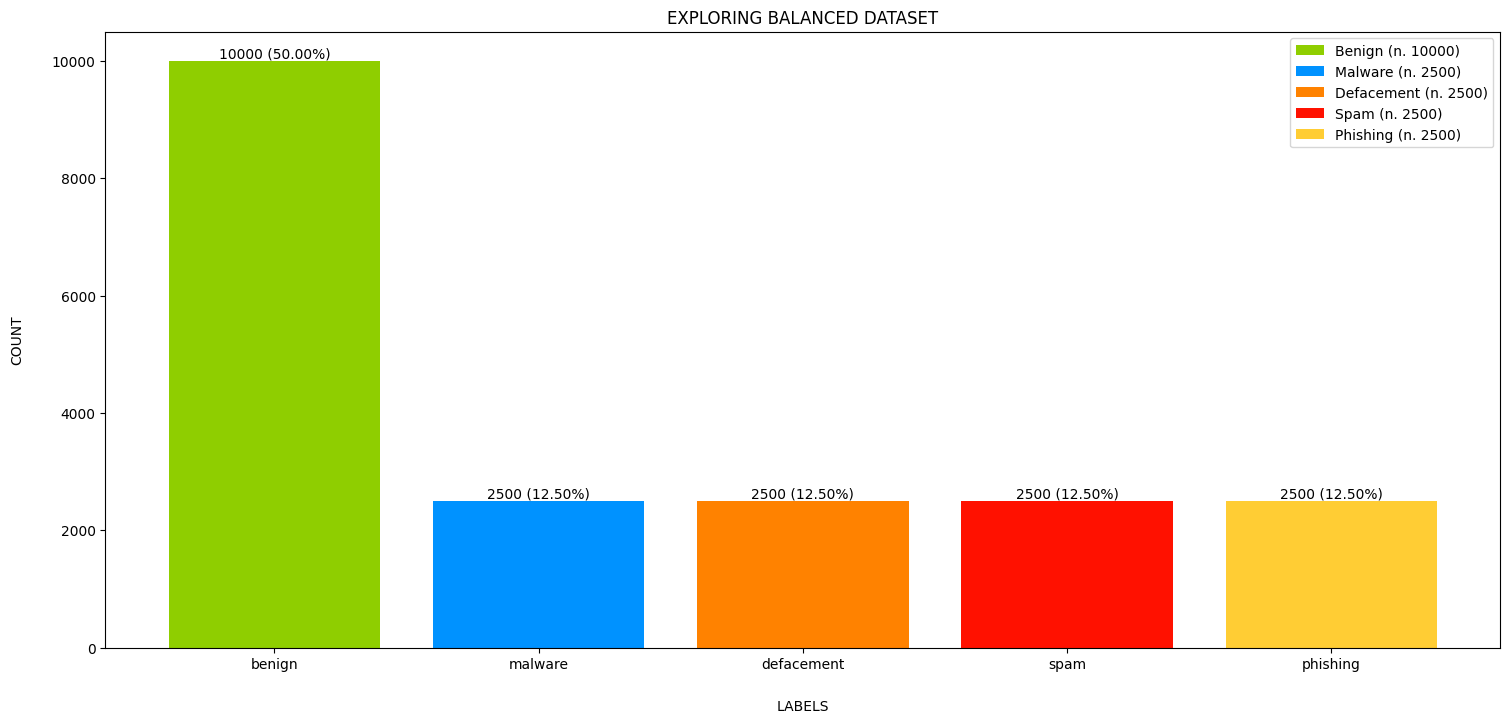

In [10]:
count = data_sampled.type.value_counts()
bar_labels = [count.index[i].capitalize()+' (n. ' + str(count[i]) + ')' for i in range(len(count.index))]
bars = plt.bar(count.index, height=count, label=bar_labels, color=['#8fce00', '#0092ff', '#ff8200', '#ff1100', '#ffcd34'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(data_sampled)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('LABELS', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING BALANCED DATASET')
plt.legend()
plt.show()

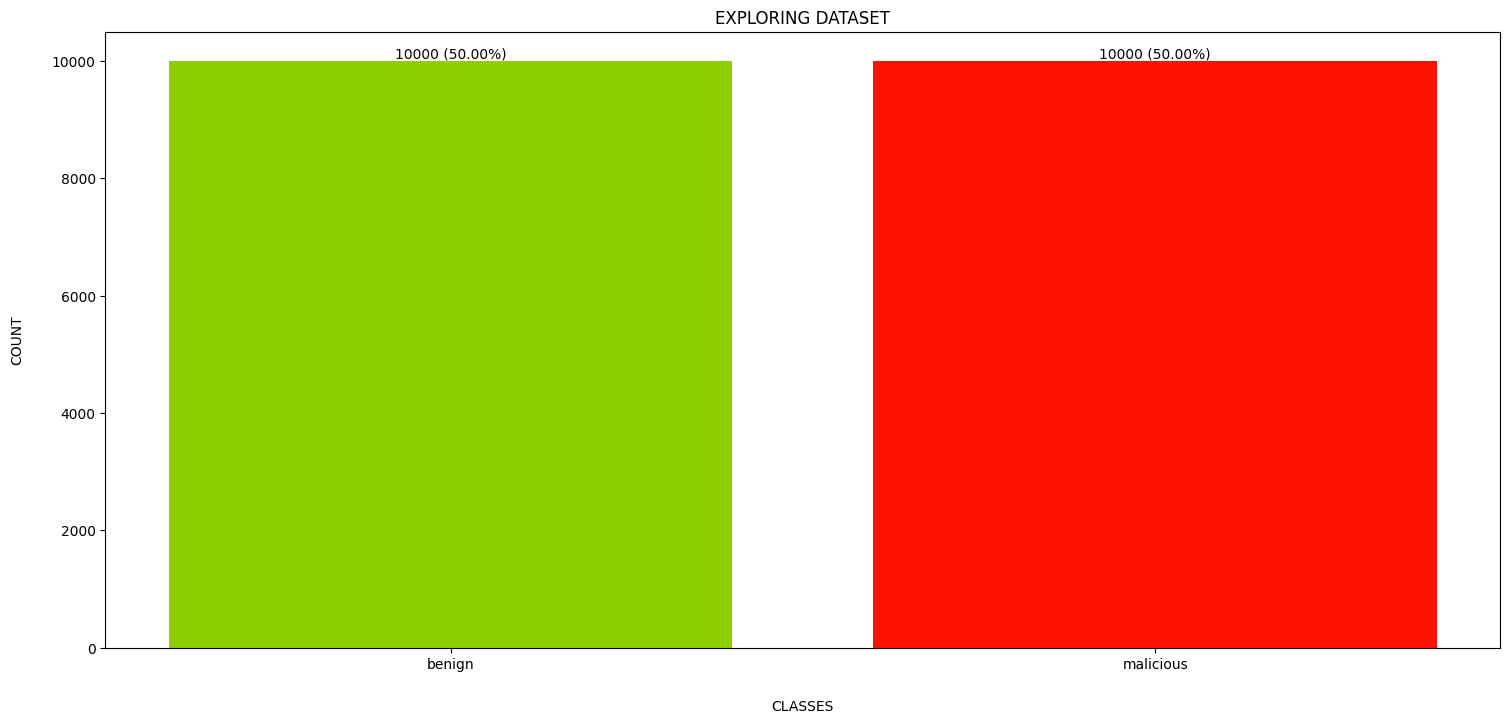

In [11]:
benign = count[0]
malicious = len(data_sampled) - benign
bar_labels = ['Benign (n.'+str(benign)+')', 'Malicious (n.'+str(malicious)+')']
bars = plt.bar(['benign', 'malicious'], height=[benign, malicious], label=bar_labels, color=['#8fce00', '#ff1100'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(data_sampled)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('CLASSES', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.show()

In [12]:
#file_path = '/content/urls_sampled.csv'
#data_sampled.to_csv(file_path, index=False)
data = pd.read_csv(DATA_PATH_URL_SAMPLED)
data.describe()

,url,type
count,20000,20000
unique,20000,5
top,http://173.15.162.156:4755/Mozi.m,benign
freq,1,10000


# **2) FEATURES ENGINEERING**

---



In [13]:
#
# Number of character '.' in URL
# Return: numeric
#
def count_dots(url: str):
    return url.count('.')


#
# Number of subdomain levels
# Return: numeric
#
def count_subdomains(url: str):
    subdomain = tldextract.extract(url).subdomain
    return len(subdomain.split('.')) if len(subdomain) != 0 else 0


#
# The depth of URL
# Return: numeric
#
def get_path_level(url: str):
    path = urlsplit(url).path
    path = path[1:] if len(path) > 0 and path[0] == '/' else path
    path = path[:-1] if len(path) > 0 and path[-1] == '/' else path
    return len(path.split('/')) if len(path) > 0 else 0


#
# The length of URL
# Return: numeric
#
def get_len(url: str):
    return len(url)


#
# Number of the dash character '-' in URL
# Return: numeric
#
def count_dash(url: str):
    return url.count('-')


#
# There exists a character '@' in URL
# Return: boolean
#
def check_at_symbol(url: str):
    return '@' in url


#
# There exists a character '~' in URL
# Return: boolean
#
def check_tilde_symbol(url: str):
    return '~' in url


#
# Number of the underscore character '_' in URL
# Return: numeric
#
def count_underscore(url: str):
    return url.count('_')


#
# Number of the percent character '%' in URL
# Return: numeric
#
def count_percent(url: str):
    return url.count('%')


#
# Number of the query components
# Return: numeric
#
def count_query_components(url: str):
    query_components = urlparse(url).query.split("&") if len(urlparse(url).query) > 0 else ''
    return len(query_components)


#
# Number of the ampersand character '&' in URL
# Return: numeric
#
def count_ampersand(url: str):
    return url.count('&')


#
# Number of the hash character '#' in URL
# Return: numeric
#
def count_hash(url: str):
    return url.count('#')


#
# Number of the numeric character
# Return: numeric
#
def count_digits(url: str):
    return sum(c.isdigit() for c in url)


#
# Check if there exists a HTTPS in website URL
# Return: boolean
#
def check_Https(url: str):
    try:
        req = requests.get(url, timeout=1).url
        return req.startswith('https')
    except Exception as e:
        return False


#
# Check if the IP address is used in the hostname of the website URL
# Return: boolean
#
def check_IP_address(url: str):
    return not bool(sum(not c.isdigit() and c != '.' for c in tldextract.extract(url).domain))


#
# Check if TLD is used as a part of the subdomain in website URL
# Return: boolean
#
def check_tld_in_subdomain(url: str):
    res = tldextract.extract(url)
    return res.domain in res.subdomain


#
# Check if TLD is used in the link of website URL
# Return: boolean
#
def check_tld_in_path(url: str):
    return tldextract.extract(url).domain in urlsplit(url).path


#
# Check if HTTPS is disordered in the hostname of website URL
# Return: boolean
#
def check_https_in_hostname(url: str):
    return 'https' in urlsplit(url).netloc


#
# Length of hostname
# Return: numeric
#
def get_hostname_length(url: str):
    return len(urlsplit(url).netloc)


#
# Length of the link path
# Return: numeric
#
def get_path_length(url: str):
    return len(urlparse(url).path)


#
# Length of the query string
# Return: numeric
#
def get_query_length(url):
    return len(urlparse(url).query)


#
# There exists a slash '//' in the link path
# Return: boolean
#
def check_double_slash_in_path(url: str):
    return '//' in urlparse(url).path


#
# Compute the lexical features by URL
# Return: Pandas.Series
#
def get_lexical_features(url, label):
    if not url.startswith(('http://', 'https://', 'ftp://')):
        url = 'http://' + url
    return [
        url,
        count_dots(url),
        count_subdomains(url),
        get_path_level(url),
        get_len(url),
        count_dash(url),
        check_at_symbol(url),
        check_tilde_symbol(url),
        count_underscore(url),
        count_percent(url),
        count_query_components(url),
        count_ampersand(url),
        count_hash(url),
        count_digits(url),
        check_Https(url),
        check_IP_address(url),
        check_tld_in_subdomain(url),
        check_tld_in_path(url),
        check_https_in_hostname(url),
        get_hostname_length(url),
        get_path_length(url),
        get_query_length(url),
        check_double_slash_in_path(url),
        label
    ]

In [15]:
data_features = pd.DataFrame({
    'url':[],
    'numDots':[],
    'subdomainLevel':[],
    'pathLevel':[],
    'urlLength':[],
    'numDash':[],
    'atSymbol':[],
    'tildeSymbol':[],
    'numUnderscore':[],
    'numPercent':[],
    'numQueryComponents':[],
    'numApersand':[],
    'numHash':[],
    'numDigits':[],
    'https':[],
    'ipAddress':[],
    'domainInSubdomains':[],
    'domainInPaths':[],
    'httpsInHostname':[],
    'hostnameLength':[],
    'pathLength':[],
    'queryLength':[],
    'doubleSlash':[],
    'type': []
})

In [16]:
## SCRIPT TO EXTRACT FEATURES AND SAVE THEM ON CSV FILE
## (EXECUTE ONLY IF NECESSARY)

# for i in range(len(data)):
#     url = data.loc[i, 'url']
#     label = data.loc[i, 'type']
#     if (i % 1000 == 0):
#         print('Rows processed: ',i)
#     try:
#         data_features.loc[i] = get_lexical_features(url, label)
#     except Exception as e:
#         print('\n')
#         print(e)
#         print('url: ',url)
#         print('index: ',i)
#         continue
# data_features.to_csv('/content/urls_with_features.csv', index = False)

# **3) EXPLORATIVE DATA ANALYSIS**

---



In [17]:
data = pd.read_csv(DATA_PATH_URL_FEATURES)
data.describe()

,numDots,subdomainLevel,pathLevel,urlLength,numDash,numUnderscore,numPercent,numQueryComponents,numApersand,numHash,numDigits,hostnameLength,pathLength,queryLength
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,2.482300,0.491650,2.169350,70.553750,1.289450,0.48425,0.365150,0.668000,0.45590,0.000650,7.918400,17.517150,27.930800,17.603400
std,1.498532,0.908775,1.548383,71.897412,2.689336,1.51399,3.837832,1.563745,1.32153,0.029148,15.195482,10.205705,26.701628,67.855277
min,0.000000,0.000000,0.000000,13.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,38.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,12.000000,10.000000,0.000000
50%,2.000000,0.000000,2.000000,53.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,4.000000,16.000000,21.000000,0.000000
75%,3.000000,1.000000,3.000000,83.000000,1.000000,0.00000,0.000000,0.000000,0.00000,0.000000,10.000000,20.000000,37.000000,0.000000
max,25.000000,18.000000,18.000000,1424.000000,39.000000,20.00000,147.000000,28.000000,27.00000,2.000000,332.000000,244.000000,755.000000,1388.000000


In [18]:
# Null values check
data.isnull().any()

url                   False
numDots               False
subdomainLevel        False
pathLevel             False
urlLength             False
numDash               False
atSymbol              False
tildeSymbol           False
numUnderscore         False
numPercent            False
numQueryComponents    False
numApersand           False
numHash               False
numDigits             False
https                 False
ipAddress             False
domainInSubdomains    False
domainInPaths         False
httpsInHostname       False
hostnameLength        False
pathLength            False
queryLength           False
doubleSlash           False
type                  False
dtype: bool

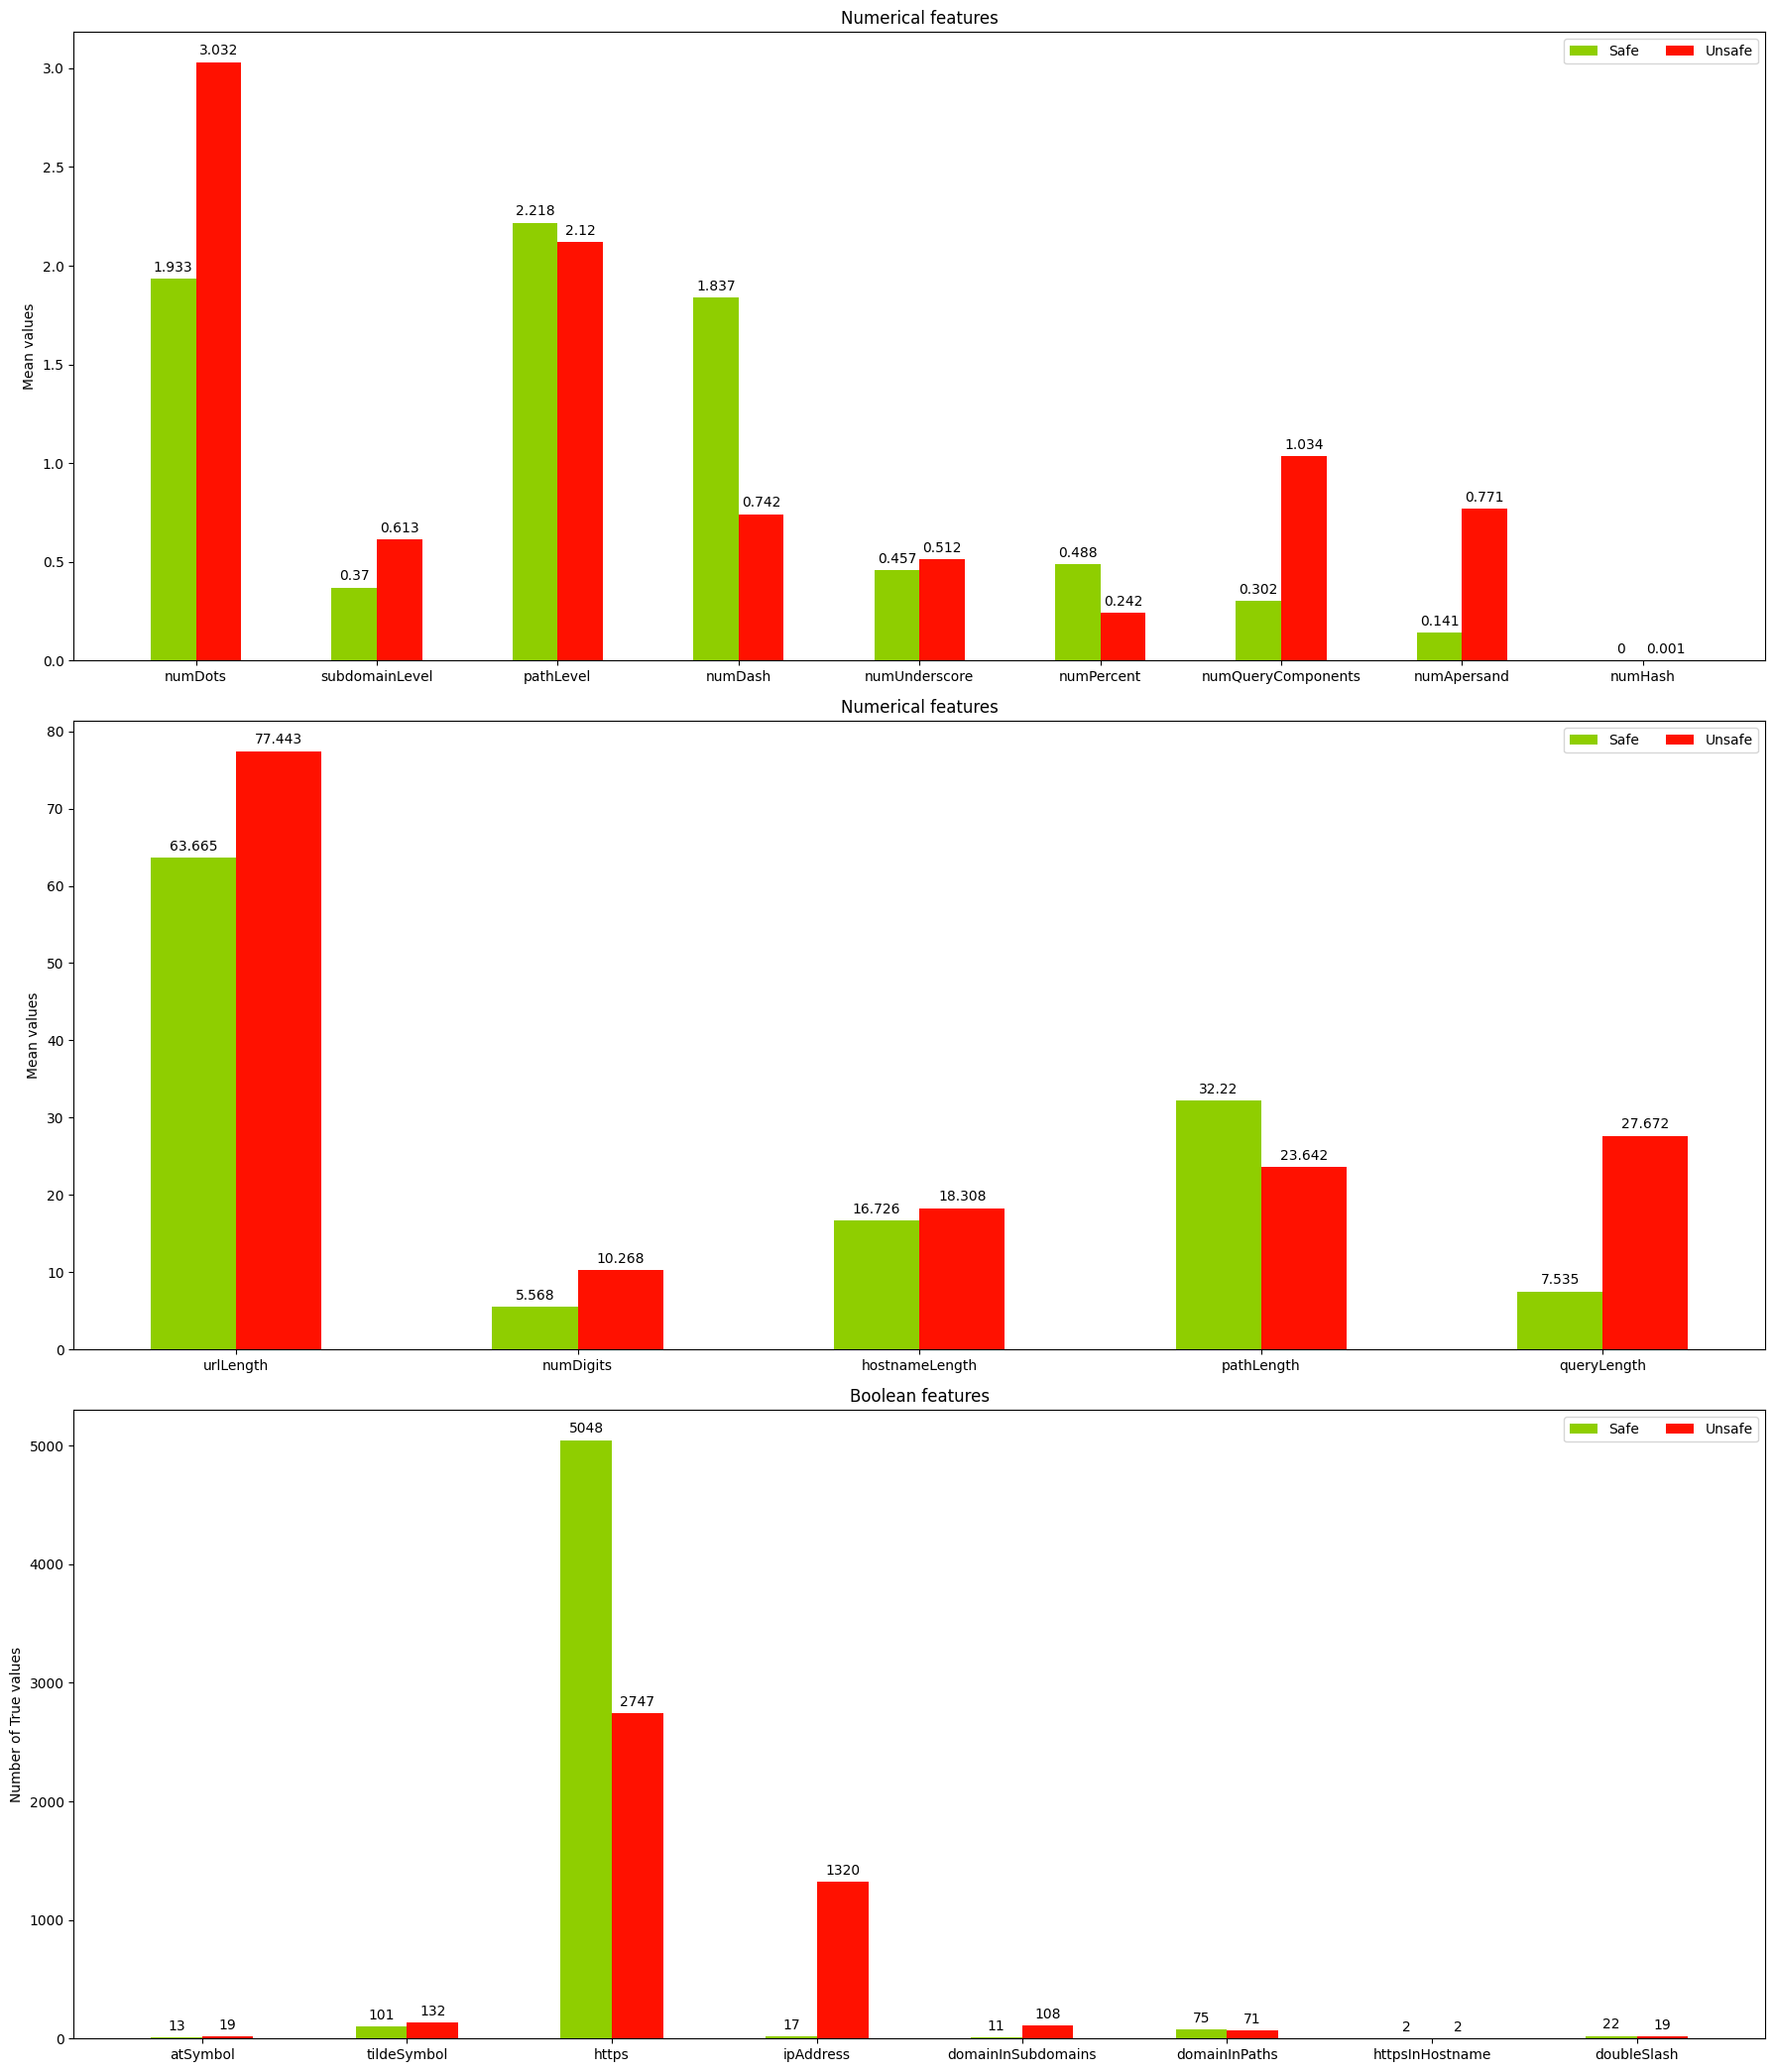

In [19]:
safe = data[data['type'] == 'benign']
unsafe = data[data['type'] != 'benign']

# Numerical features
labels_x1 = ['numDots', 'subdomainLevel', 'pathLevel', 'numDash', 'numUnderscore', 'numPercent', 'numQueryComponents', 'numApersand', 'numHash']
labels_x2 = ['urlLength', 'numDigits', 'hostnameLength', 'pathLength', 'queryLength']
# Boolean features
labels_x3 = ['atSymbol', 'tildeSymbol', 'https', 'ipAddress', 'domainInSubdomains', 'domainInPaths', 'httpsInHostname', 'doubleSlash']

features_to_plot1 = {'Safe': [], 'Unsafe': []}
features_to_plot2 = {'Safe': [], 'Unsafe': []}
features_to_plot3 = {'Safe': [], 'Unsafe': []}

for i in labels_x1:
    features_to_plot1['Safe'].append(safe.loc[:, i].mean())
    features_to_plot1['Unsafe'].append(unsafe.loc[:, i].mean())

for i in labels_x2:
    features_to_plot2['Safe'].append(safe.loc[:, i].mean())
    features_to_plot2['Unsafe'].append(unsafe.loc[:, i].mean())

for i in labels_x3:
    features_to_plot3['Safe'].append(safe.loc[:, i].sum())
    features_to_plot3['Unsafe'].append(unsafe.loc[:, i].sum())

x1 = np.arange(len(labels_x1))  # the label locations
x2 = np.arange(len(labels_x2))  # the label locations
x3 = np.arange(len(labels_x3))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(18, 21))

for attribute, measurement in features_to_plot1.items():
    offset = width * multiplier
    rects = ax1.bar(x1 + offset, [round(i,3) for i in measurement], width, label = attribute, color = ['#8fce00' if attribute == 'Safe' else '#ff1100'])
    ax1.bar_label(rects, padding = 3)
    multiplier += 1
ax1.set_ylabel('Mean values')
ax1.set_title('Numerical features')
ax1.set_xticks(x1 + (width/2), labels_x1)
ax1.legend(loc = 'upper right', ncol = 2)

for attribute, measurement in features_to_plot2.items():
    offset = width * multiplier
    rects = ax2.bar(x2 + offset, [round(i,3) for i in measurement], width, label = attribute, color = ['#8fce00' if attribute == 'Safe' else '#ff1100'])
    ax2.bar_label(rects, padding = 3)
    multiplier += 1
ax2.set_ylabel('Mean values')
ax2.set_title('Numerical features')
ax2.set_xticks(x2 + (width*2.5), labels_x2)
ax2.legend(loc = 'upper right', ncol = 2)

for attribute, measurement in features_to_plot3.items():
    offset = width * multiplier
    rects = ax3.bar(x3 + offset, [round(i,3) for i in measurement], width, label = attribute, color = ['#8fce00' if attribute == 'Safe' else '#ff1100'])
    ax3.bar_label(rects, padding = 3)
    multiplier += 1
ax3.set_ylabel('Number of True values')
ax3.set_title('Boolean features')
ax3.set_xticks(x3 + (width*4.5), labels_x3)
ax3.legend(loc = 'upper right', ncol = 2)

plt.tight_layout()
plt.show()

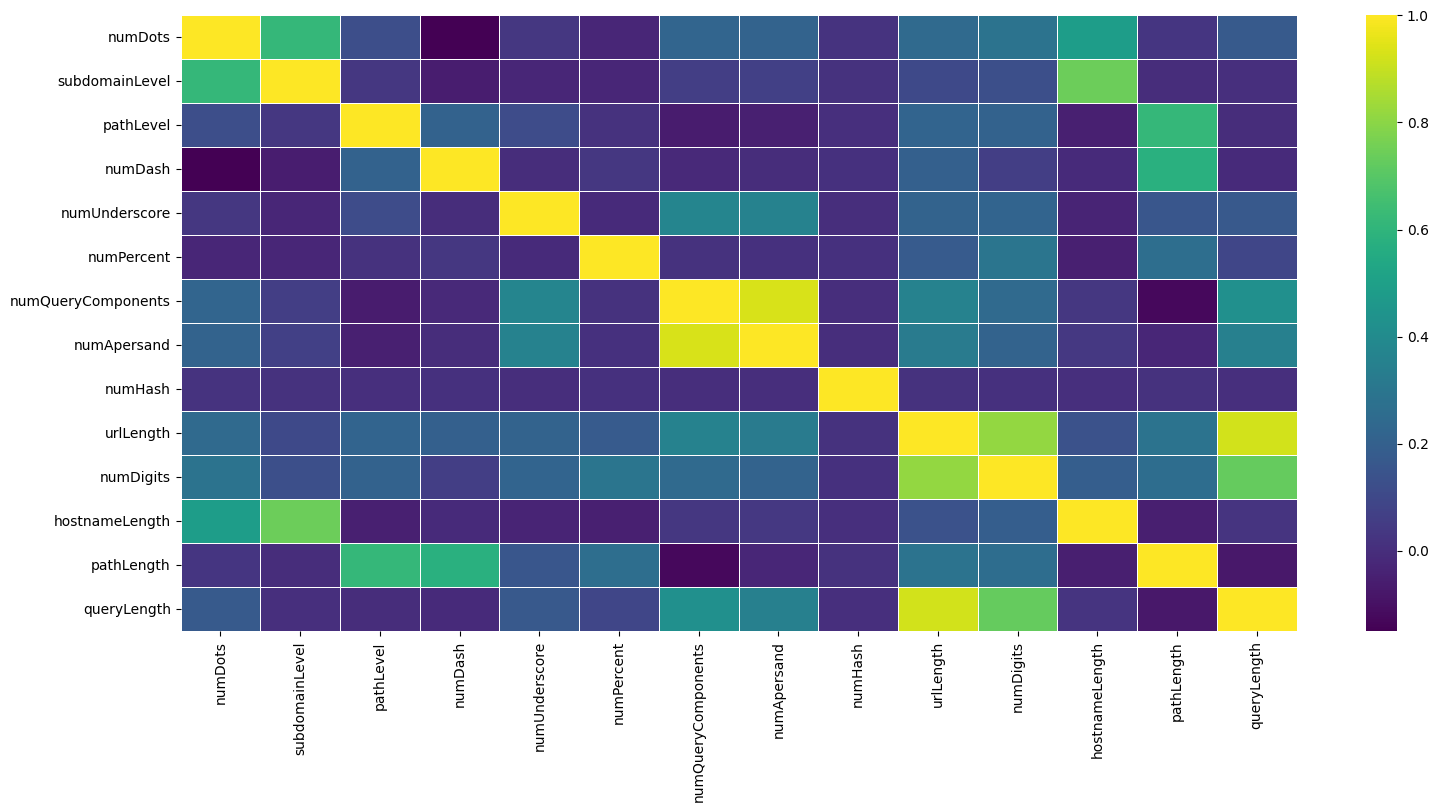

In [20]:
sns.heatmap(data[labels_x1+labels_x2].corr(), linewidths=.5, fmt="g", cmap='viridis')
plt.show()

# **4) FEATURES SELECTION**

---



In [21]:
selected_features = ['numDots', 'subdomainLevel', 'pathLevel', 'urlLength', 'numDash',
       'numUnderscore', 'numPercent', 'numQueryComponents', 'numApersand', 'numDigits', 'https',
       'ipAddress', 'hostnameLength', 'pathLength', 'queryLength']

X = data[selected_features]
X.https = X.https.replace({True: 1, False: 0})
X.ipAddress = X.ipAddress.replace({True: 1, False: 0})

y = data[['type']]
y.loc[y['type'] != 'benign', 'type'] = 1
y.loc[y['type'] == 'benign', 'type'] = 0

In [22]:
## Custom function to split data
def get_data_split(X, y, isScaled=False, isTensor=False, fSelection=[]):

    if len(fSelection) > 0:
        X = X[fSelection]

    if isScaled:
        scaler = MinMaxScaler()
        X_scal = X
        for c in X_scal:
            if c != 'ipAddress' or c != 'https':
                X_scal[[c]] = scaler.fit_transform(X_scal[[c]])
        X = X_scal

    X_train, X_test, y_train, y_test = train_test_split(
                                            X.values.astype('float64'),
                                            y.values.astype('float64'),
                                            train_size = .8,
                                            test_size = .2,
                                            random_state = 2,
                                            shuffle = True,
                                            stratify = y)

    if isTensor:
        X_train = torch.tensor(data = X_train, dtype=torch.float32).to(device)
        X_test = torch.tensor(data = X_test, dtype=torch.float32).to(device)
        y_train = torch.tensor(data = y_train.squeeze(), dtype=torch.float32).to(device)
        y_test = torch.tensor(data = y_test.squeeze(), dtype=torch.float32).to(device)

    return X_train, X_test, y_train, y_test

## **Principal Component Analysis (PCA)**

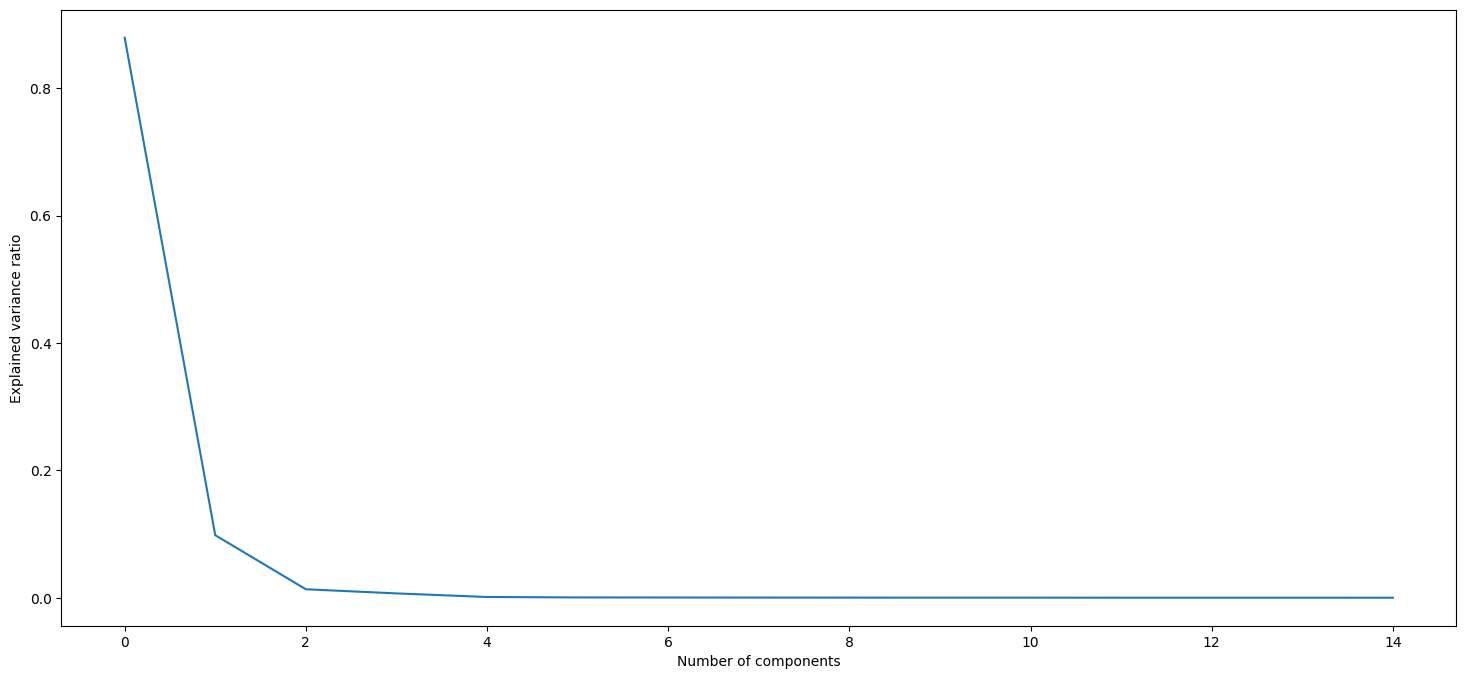

In [23]:
# Create a PCA object and fit the data
pca = PCA()
pca.fit(X)

# Plot the explained variance ratio for each component
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.show()

In [24]:
def get_pca_features(components: int):
    pca = PCA(n_components = components)
    return pca.fit_transform(X.values)

## **Autoencoder**

In [110]:
n_inputs = X.values.shape[1]
n_inputs

15

In [121]:
X_train, X_test, y_train, y_test = get_data_split(X, y, isScaled=True)

# Define autoencoder
visible = Input(shape = (n_inputs,))

#Define Encoder
#level 1
e = Dense(n_inputs*2)(visible) # e = encoder
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

#Bottleneck
n_bottleneck = round(float(n_inputs)/2.0)
bottleneck = Dense(n_bottleneck)(e)

# Define Decoder
#level 1
d = Dense(n_inputs)(bottleneck) # d = dencoder
d = BatchNormalization()(d)
d = LeakyReLU()(d)

#level 2
d = Dense(n_inputs*2)(d) # d = dencoder
d = BatchNormalization()(d)
d = LeakyReLU()(d)

#Output layer
output = Dense(n_inputs, activation = 'linear')(d)

#Define autoencoder model
model = Model(inputs = visible, outputs = output)

#compile autoencoder
model.compile(optimizer = 'adam', loss = 'mse')

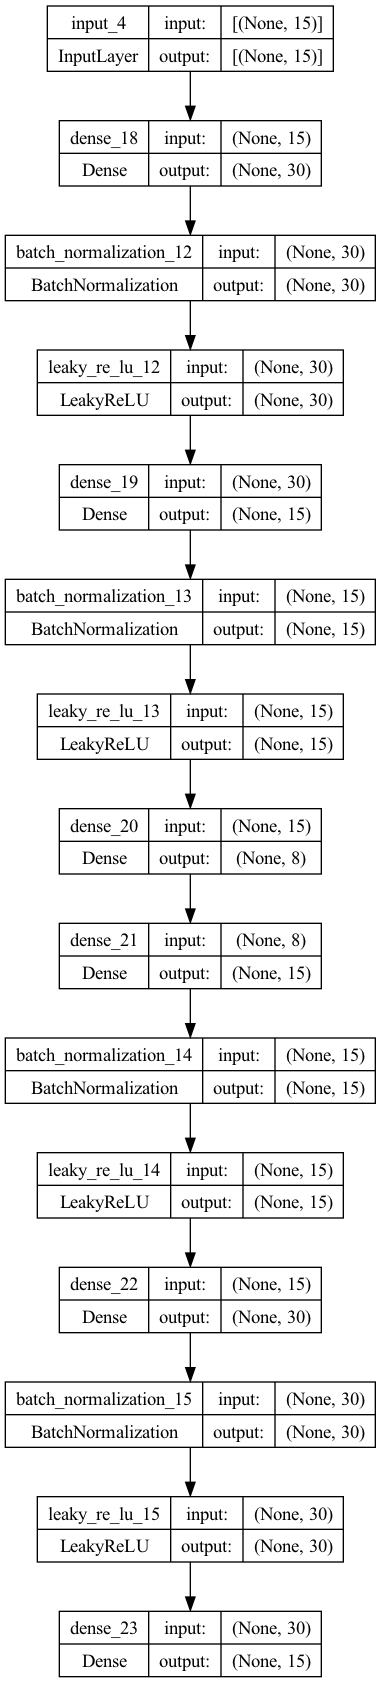

In [122]:
# Plot the autoencoder architecture
plot_model(model, to_file='autoencoder_architecture.png', show_shapes=True, show_layer_names=True)

In [123]:
# Fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs = 20, batch_size = 16, verbose = 2, validation_data = (X_test,X_test))

Epoch 1/20
1000/1000 - 1s - loss: 0.0227 - val_loss: 0.0026 - 1s/epoch - 1ms/step
Epoch 2/20
1000/1000 - 1s - loss: 0.0039 - val_loss: 0.0018 - 695ms/epoch - 695us/step
Epoch 3/20
1000/1000 - 1s - loss: 0.0028 - val_loss: 0.0018 - 691ms/epoch - 691us/step
Epoch 4/20
1000/1000 - 1s - loss: 0.0025 - val_loss: 0.0013 - 720ms/epoch - 720us/step
Epoch 5/20
1000/1000 - 1s - loss: 0.0019 - val_loss: 0.0011 - 701ms/epoch - 701us/step
Epoch 6/20
1000/1000 - 1s - loss: 0.0016 - val_loss: 9.2572e-04 - 687ms/epoch - 687us/step
Epoch 7/20
1000/1000 - 1s - loss: 0.0014 - val_loss: 0.0012 - 692ms/epoch - 692us/step
Epoch 8/20
1000/1000 - 1s - loss: 0.0012 - val_loss: 9.9841e-04 - 679ms/epoch - 679us/step
Epoch 9/20
1000/1000 - 1s - loss: 0.0011 - val_loss: 7.1549e-04 - 678ms/epoch - 678us/step
Epoch 10/20
1000/1000 - 1s - loss: 9.5279e-04 - val_loss: 8.6856e-04 - 681ms/epoch - 681us/step
Epoch 11/20
1000/1000 - 1s - loss: 9.9833e-04 - val_loss: 8.2898e-04 - 698ms/epoch - 698us/step
Epoch 12/20
1000/1

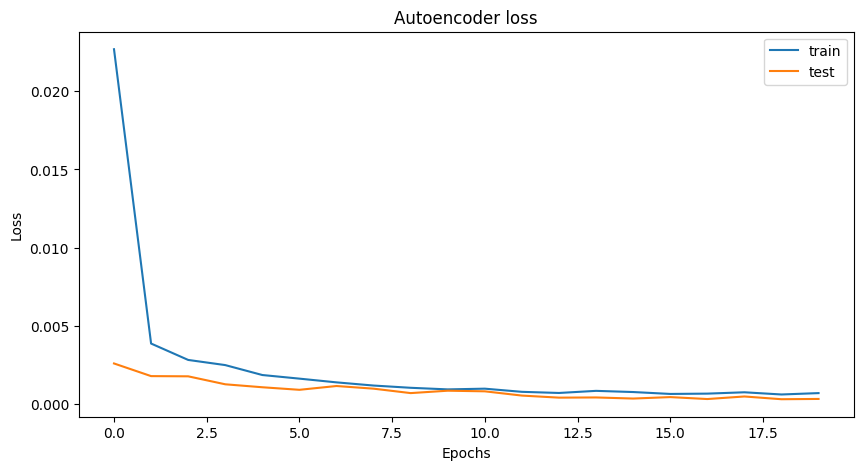

In [124]:
#Plot Loss
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.title('Autoencoder loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('Autoencoderloss.png')

In [125]:
#Define an encoder model without the decoder
encoder = Model(inputs =visible, outputs = bottleneck)

# encode the  data
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)

125/125 [==============================] - 0s 248us/step


In [126]:
X_train_encode.shape

(16000, 8)

# **5) MODELS DEFINITION**

---



## **1) Support Vector Machine**

In [32]:
X_train, X_test, y_train, y_test = get_data_split(X, y)
start_time = time.time()
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
end_time = time.time()
acc = accuracy_score(pred, y_test)
exec_svm_all = end_time - start_time
print(f'Test Accuracy:\033[32m \033[01m {acc*100:.2f}% \033[30m \033[0m')
print(f'Execution Time:\033[32m \033[01m {exec_svm_all:.2f}s \033[30m \033[0m \n')
print(classification_report(y_test, pred, target_names=['safe_URL', 'unsafe_URL']))

Test Accuracy:  79.17%  
Execution Time:  4.20s   

              precision    recall  f1-score   support

    safe_URL       0.80      0.78      0.79      2000
  unsafe_URL       0.79      0.80      0.79      2000

    accuracy                           0.79      4000
   macro avg       0.79      0.79      0.79      4000
weighted avg       0.79      0.79      0.79      4000



## **2) AdaBoost**

In [33]:
X_train, X_test, y_train, y_test = get_data_split(X, y)
start_time = time.time()
adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)
pred = adaboost.predict(X_test)
end_time = time.time()
acc = accuracy_score(pred, y_test)
exec_ada_all = end_time - start_time
print(f'Test Accuracy:\033[32m \033[01m {acc*100:.2f}% \033[30m \033[0m')
print(f'Execution Time:\033[32m \033[01m {exec_ada_all:.2f}s \033[30m \033[0m \n')
print(classification_report(y_test, pred, target_names=['safe_URL', 'unsafe_URL']))

Test Accuracy:  83.20%  
Execution Time:  0.32s   

              precision    recall  f1-score   support

    safe_URL       0.82      0.85      0.84      2000
  unsafe_URL       0.85      0.81      0.83      2000

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



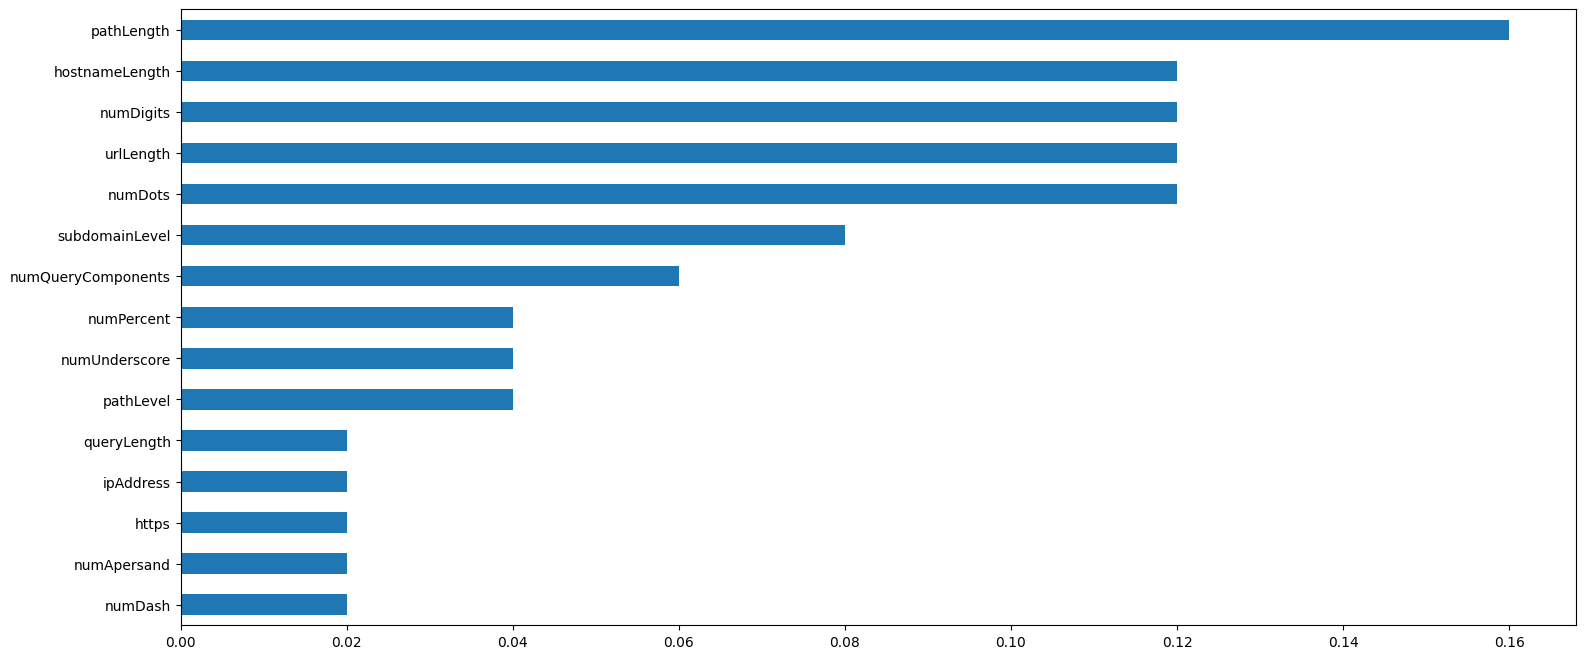

In [34]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

In [35]:
fSelection_adaboost = ['pathLength', 'hostnameLength', 'numDigits', 'urlLength', 'numDots']
X_train_short, X_test_short, _, _ = get_data_split(X, y, fSelection=fSelection_adaboost)
start_time = time.time()
adaboost = AdaBoostClassifier()
adaboost.fit(X_train_short, y_train)
pred = adaboost.predict(X_test_short)
end_time = time.time()
acc = accuracy_score(pred, y_test)
print(f'Test Accuracy:\033[32m \033[01m {acc*100:.2f}% \033[30m \033[0m')
print(f'Execution Time:\033[32m \033[01m {end_time-start_time:.2f}s \033[30m \033[0m \n')
print(classification_report(y_test, pred, target_names=['safe_URL', 'unsafe_URL']))

Test Accuracy:  82.03%  
Execution Time:  0.20s   

              precision    recall  f1-score   support

    safe_URL       0.81      0.83      0.82      2000
  unsafe_URL       0.83      0.81      0.82      2000

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



## **3) Random Forest**

In [36]:
X_train, X_test, y_train, y_test = get_data_split(X, y)
start_time = time.time()
rf = RandomForestClassifier(random_state=3)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
end_time = time.time()
acc = accuracy_score(pred, y_test)
exec_rf_all = end_time - start_time
print(f'Test Accuracy:\033[32m \033[01m {acc*100:.2f}% \033[30m \033[0m')
print(f'Execution Time:\033[32m \033[01m {exec_rf_all:.2f}s \033[30m \033[0m \n')
print(classification_report(y_test, pred, target_names=['safe_URL', 'unsafe_URL']))

Test Accuracy:  89.30%  
Execution Time:  0.77s   

              precision    recall  f1-score   support

    safe_URL       0.89      0.90      0.89      2000
  unsafe_URL       0.90      0.88      0.89      2000

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



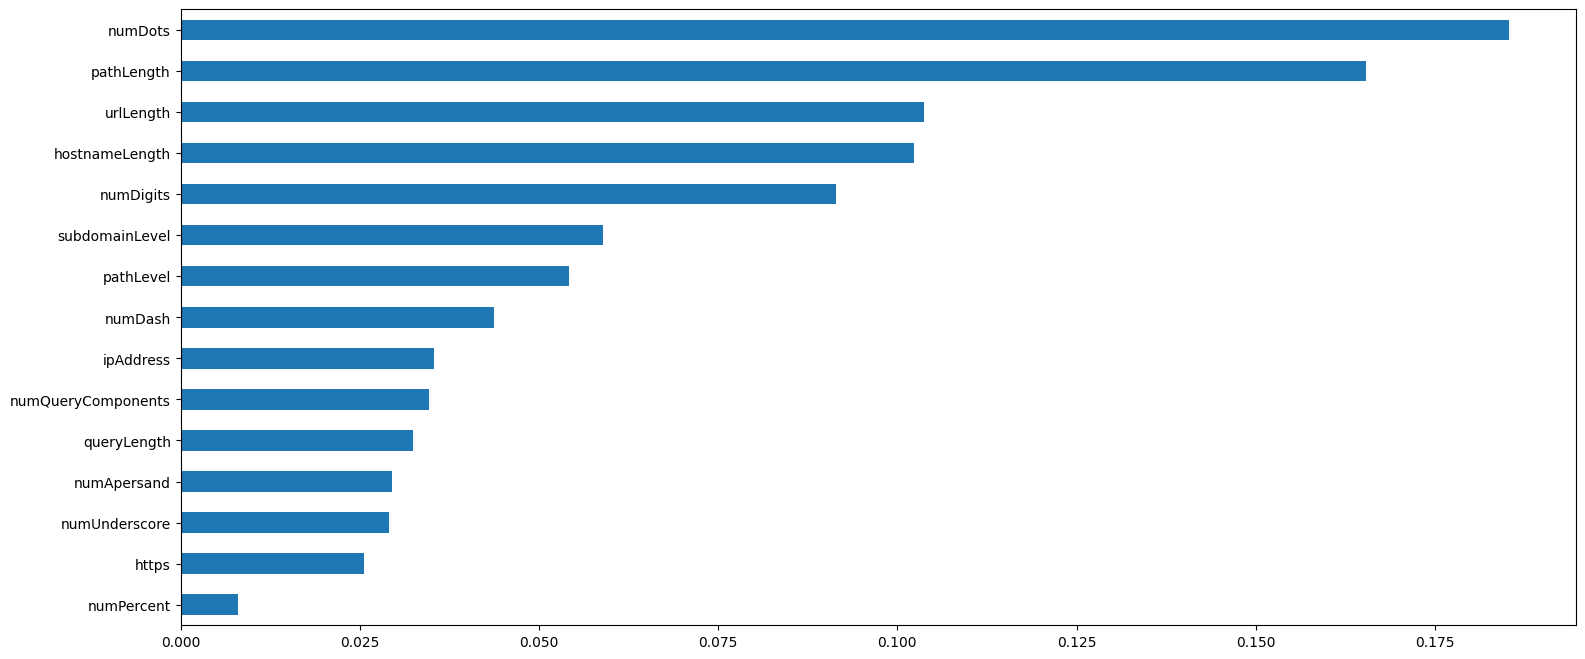

In [37]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

In [38]:
fSelection = ['numDots', 'pathLength', 'urlLength', 'hostnameLength']
X_train_short, X_test_short, _, _ = get_data_split(X, y, fSelection=fSelection)
start_time = time.time()
rf = RandomForestClassifier(random_state=3)
rf.fit(X_train_short, y_train)
pred_short = rf.predict(X_test_short)
end_time = time.time()
acc_short = accuracy_score(pred_short, y_test)
print(f'Test Accuracy:\033[32m \033[01m {acc_short*100:.2f}% \033[30m \033[0m')
print(f'Execution Time:\033[32m \033[01m {end_time-start_time:.2f}s \033[30m \033[0m \n')
print(classification_report(y_test, pred, target_names=['safe_URL', 'unsafe_URL']))

Test Accuracy:  84.35%  
Execution Time:  0.82s   

              precision    recall  f1-score   support

    safe_URL       0.89      0.90      0.89      2000
  unsafe_URL       0.90      0.88      0.89      2000

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



## **4) Neural Network**

In [39]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

class MySimpleNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.tanh(self.output(x))
        return x

In [40]:
def fit_NN(net, X_train_net, X_eval_net, y_train_net, y_eval_net, n_epochs, verbose=(True,100)):

    torch.manual_seed(42)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.1)
    metrics = {'trainLoss': [],'evalLoss': [],'trainAcc': [],'evalAcc': []}

    for epoch in range(n_epochs):

        ### Training
        net.train()

        # 1. Forward pass (model outputs raw logits)
        y_logits = net(X_train_net).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

        # 2. Calculate loss/accuracy
        loss = loss_fn(y_logits, y_train_net) # Using nn.BCEWithLogitsLoss works with raw logits
        acc = accuracy_fn(y_true=y_train_net, y_pred=y_pred)
        metrics['trainLoss'].append(loss.detach().cpu().numpy())
        metrics['trainAcc'].append(acc)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        ### Testing
        net.eval()
        with torch.inference_mode():
            # 1. Forward pass
            test_logits = net(X_eval_net).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
            # 2. Caculate loss/accuracy
            test_loss = loss_fn(test_logits, y_eval_net)
            test_acc = accuracy_fn(y_true=y_eval_net, y_pred=test_pred)
            metrics['evalLoss'].append(test_loss.detach().cpu().numpy())
            metrics['evalAcc'].append(test_acc)


        # Print out what's happening every 100 epochs
        if epoch % verbose[1] == 0 and verbose[0] == True:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    
    return net, metrics

In [41]:
def predict_NN(net, X_test_net, y_test_net):
    torch.manual_seed(42)
    net.eval()
    with torch.no_grad():
        test_logits = net(X_test_net).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_acc = accuracy_fn(y_true=y_test_net, y_pred=test_pred)
    return test_acc, test_pred

In [42]:
X_train_net, X_test_net, y_train_net, y_test_net = get_data_split(X, y, isTensor=True)
split = int(len(X_train_net) * .8)
X_eval_net = X_train_net[split:]
y_eval_net = y_train_net[split:]
X_train_net = X_train_net[:split]
y_train_net = y_train_net[:split]
start_time = time.time()
net = MySimpleNetwork(X_train_net.shape[1]).to(device)
model, metrics = fit_NN(net, X_train_net, X_eval_net, y_train_net, y_eval_net, n_epochs=2000, verbose=(True,400))
accuracy_nn, pred = predict_NN(model, X_test_net, y_test_net)
end_time = time.time()
exec_nn_all = end_time-start_time

Epoch: 0 | Loss: 0.69368, Accuracy: 50.11% | Test loss: 0.69376, Test acc: 49.56%
Epoch: 400 | Loss: 0.65267, Accuracy: 61.54% | Test loss: 0.65222, Test acc: 61.47%
Epoch: 800 | Loss: 0.59030, Accuracy: 72.73% | Test loss: 0.59111, Test acc: 71.97%
Epoch: 1200 | Loss: 0.54118, Accuracy: 76.64% | Test loss: 0.54162, Test acc: 76.69%
Epoch: 1600 | Loss: 0.53480, Accuracy: 76.57% | Test loss: 0.53376, Test acc: 77.19%


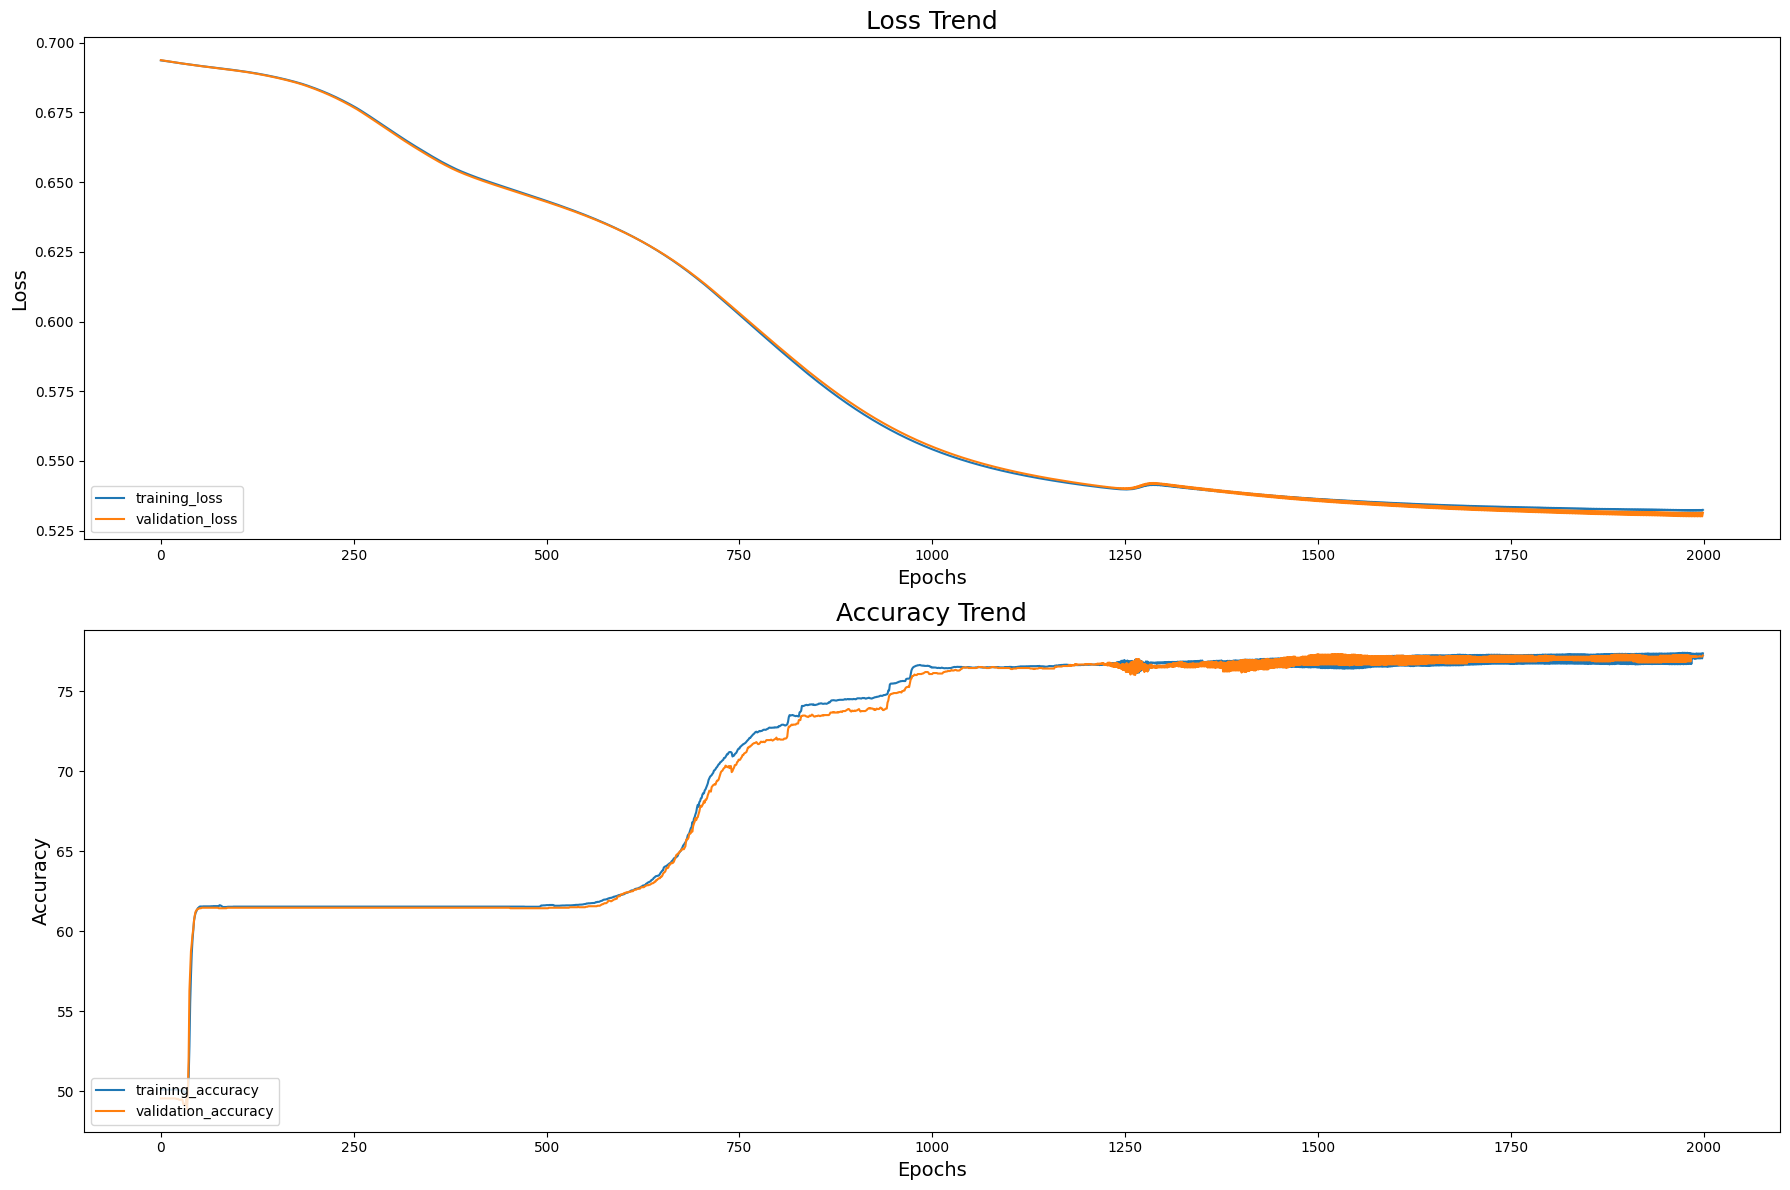

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))
ax1.plot(metrics['trainLoss'], label='training_loss')
ax1.plot(metrics['evalLoss'], label='validation_loss')
ax1.set_title('Loss Trend', fontsize = 18)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend(loc='lower left')
ax2.plot(metrics['trainAcc'], label='training_accuracy')
ax2.plot(metrics['evalAcc'], label='validation_accuracy')
ax2.set_title('Accuracy Trend', fontsize = 18)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.legend(loc='lower left')

plt.tight_layout()
plt.show()

In [44]:
print(f'\nTest Accuracy:\033[32m \033[01m {accuracy_nn:.2f}% \033[30m \033[0m')
print(f'Execution Time:\033[32m \033[01m {exec_nn_all:.2f}s \033[30m \033[0m \n')
print(classification_report(y_test_net.detach().cpu().numpy(), pred.detach().cpu().numpy(), target_names=['safe_URL', 'unsafe_URL']))


Test Accuracy:  78.38%  
Execution Time:  8.80s   

              precision    recall  f1-score   support

    safe_URL       0.80      0.76      0.78      2000
  unsafe_URL       0.77      0.81      0.79      2000

    accuracy                           0.78      4000
   macro avg       0.78      0.78      0.78      4000
weighted avg       0.78      0.78      0.78      4000



# **6) EXPERIMENTAL PLAYGROUND**

---



## **1) Choosing the best features**

### SVM

In [127]:
# SVM WITH PCA FEATURES
_, _, y_train, y_test = get_data_split(X, y)
features_PCA = {}
for i in range(2,10,2):
    X_pca_i = get_pca_features(i)
    # Split dataset
    X_train_pca, X_test_pca, y_train, y_test = train_test_split(
        X_pca_i.astype('float64'),
        y.values.astype('float64'),
        train_size = .8,
        test_size = .2,
        random_state = 2,
        shuffle = True,
        stratify = y)
    key_i = str(i)
    features_PCA[key_i] = {}
    features_PCA[key_i]['X_train'] = X_train_pca
    features_PCA[key_i]['X_test'] = X_test_pca

# Training and evaluate SVM on different number of components
scores_svm = {}
for k in features_PCA.keys():
    X_train = features_PCA[k]['X_train']
    X_test = features_PCA[k]['X_test']
    # Model definition
    start_time = time.time()
    svc_i = SVC(kernel='rbf')
    svc_i.fit(X_train, y_train)
    pred_i = svc_i.predict(X_test)
    end_time = time.time()
    scores_svm['PCA_'+str(k)] = {}
    scores_svm['PCA_'+str(k)]['acc'] = accuracy_score(pred_i, y_test)
    scores_svm['PCA_'+str(k)]['prec'] = precision_score(pred_i, y_test)
    scores_svm['PCA_'+str(k)]['rec'] = recall_score(pred_i, y_test)
    scores_svm['PCA_'+str(k)]['f1'] = f1_score(pred_i, y_test)
    scores_svm['PCA_'+str(k)]['time'] = end_time - start_time

# SVM WITH AUTOENCODER FEATURES
start_time = time.time()
svc = SVC(kernel='rbf')
svc.fit(X_train_encode, y_train)
pred = svc.predict(X_test_encode)
end_time = time.time()
scores_svm['AE_8'] = {}
scores_svm['AE_8']['acc'] = accuracy_score(pred, y_test)
scores_svm['AE_8']['prec'] = precision_score(pred, y_test)
scores_svm['AE_8']['rec'] = recall_score(pred, y_test)
scores_svm['AE_8']['f1'] = f1_score(pred, y_test)
scores_svm['AE_8']['time'] = end_time - start_time

# SVM WITH ALL FEATURES
X_train, X_test, y_train, y_test = get_data_split(X, y)
start_time = time.time()
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
end_time = time.time()
scores_svm['ALL_FEATURES'] = {}
scores_svm['ALL_FEATURES']['acc'] = accuracy_score(pred, y_test)
scores_svm['ALL_FEATURES']['prec'] = precision_score(pred, y_test)
scores_svm['ALL_FEATURES']['rec'] = recall_score(pred, y_test)
scores_svm['ALL_FEATURES']['f1'] = f1_score(pred, y_test)
scores_svm['ALL_FEATURES']['time'] = end_time - start_time

In [128]:
print(''.join(['> ' for i in range(50)]))
print(f'\n{"FEATURES":<15}{"PRECISION":>15}{"RECALL":>15}{"F1":>15}{"ACCURACY":>15}{"EXEC. TIME":>15}\n')
print(''.join(['> ' for i in range(50)]))
s = scores_svm
for k in s.keys():
    if k is 'ALL_FEATURES':
        print(f'\n\033[1m{k:<15}\033[0m \033[1m{s[k]["prec"]:>14.3f}\033[0m \033[1m{s[k]["rec"]:>14.3f}\033[0m \033[1m{s[k]["f1"]:>14.3f}\033[0m \033[1m{s[k]["acc"]:>14.3f}\033[0m \033[1m{s[k]["time"]:>14.2f}\033[0m ')
    else:
        print(f'\n{k:<15}{s[k]["prec"]:>15.3f}{s[k]["rec"]:>15.3f}{s[k]["f1"]:>15.3f}{s[k]["acc"]:>15.3f}{s[k]["time"]:>15.2f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

FEATURES             PRECISION         RECALL             F1       ACCURACY     EXEC. TIME

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

PCA_2                    0.721          0.594          0.651          0.614           4.32

PCA_4                    0.472          0.799          0.593          0.676           4.16

PCA_6                    0.795          0.775          0.785          0.782           3.74

PCA_8                    0.806          0.776          0.791          0.787           3.51

AE_8                     0.790          0.782          0.786          0.785           3.59

ALL_FEATURES             0.802          0.786          0.794          0.792           4.15 


### ADABoost

In [129]:
# ADABOOST WITH PCA FEATURES
_, _, y_train, y_test = get_data_split(X, y)
scores_ada = {}
for k in features_PCA.keys():
    X_train = features_PCA[k]['X_train']
    X_test = features_PCA[k]['X_test']
    start_time = time.time()
    adaboost = AdaBoostClassifier()
    adaboost.fit(X_train, y_train)
    pred_i = adaboost.predict(X_test)
    end_time = time.time()
    scores_ada['PCA_'+str(k)] = {}
    scores_ada['PCA_'+str(k)]['acc'] = accuracy_score(pred_i, y_test)
    scores_ada['PCA_'+str(k)]['prec'] = precision_score(pred_i, y_test)
    scores_ada['PCA_'+str(k)]['rec'] = recall_score(pred_i, y_test)
    scores_ada['PCA_'+str(k)]['f1'] = f1_score(pred_i, y_test)
    scores_ada['PCA_'+str(k)]['time'] = end_time - start_time

# ADABOOST WITH AUTOENCODER FEATURES
start_time = time.time()
adaboost = AdaBoostClassifier()
adaboost.fit(X_train_encode, y_train)
pred = adaboost.predict(X_test_encode)
end_time = time.time()
scores_ada['AE_8'] = {}
scores_ada['AE_8']['acc'] = accuracy_score(pred, y_test)
scores_ada['AE_8']['prec'] = precision_score(pred, y_test)
scores_ada['AE_8']['rec'] = recall_score(pred, y_test)
scores_ada['AE_8']['f1'] = f1_score(pred, y_test)
scores_ada['AE_8']['time'] = end_time - start_time

# ADABOOST WITH ALL FEATURES
X_train, X_test, y_train, y_test = get_data_split(X, y)
start_time = time.time()
adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)
pred = adaboost.predict(X_test)
end_time = time.time()
scores_ada['ALL_FEATURES'] = {}
scores_ada['ALL_FEATURES']['acc'] = accuracy_score(pred, y_test)
scores_ada['ALL_FEATURES']['prec'] = precision_score(pred, y_test)
scores_ada['ALL_FEATURES']['rec'] = recall_score(pred, y_test)
scores_ada['ALL_FEATURES']['f1'] = f1_score(pred, y_test)
scores_ada['ALL_FEATURES']['time'] = end_time - start_time

In [130]:
print(''.join(['> ' for i in range(50)]))
print(f'\n{"FEATURES":<15}{"PRECISION":>15}{"RECALL":>15}{"F1":>15}{"ACCURACY":>15}{"EXEC. TIME":>15}\n')
print(''.join(['> ' for i in range(50)]))
s = scores_ada
for k in s.keys():
    if k is 'ALL_FEATURES':
        print(f'\n\033[1m{k:<15}\033[0m \033[1m{s[k]["prec"]:>14.3f}\033[0m \033[1m{s[k]["rec"]:>14.3f}\033[0m \033[1m{s[k]["f1"]:>14.3f}\033[0m \033[1m{s[k]["acc"]:>14.3f}\033[0m \033[1m{s[k]["time"]:>14.2f}\033[0m ')
    else:
        print(f'\n{k:<15}{s[k]["prec"]:>15.3f}{s[k]["rec"]:>15.3f}{s[k]["f1"]:>15.3f}{s[k]["acc"]:>15.3f}{s[k]["time"]:>15.2f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

FEATURES             PRECISION         RECALL             F1       ACCURACY     EXEC. TIME

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

PCA_2                    0.708          0.759          0.733          0.742           0.23

PCA_4                    0.731          0.791          0.759          0.768           0.34

PCA_6                    0.779          0.783          0.781          0.782           0.47

PCA_8                    0.746          0.808          0.776          0.784           0.63

AE_8                     0.756          0.772          0.764          0.766           0.62

ALL_FEATURES             0.810          0.847          0.828          0.832           0.29 


### Random Forest

In [131]:
# RANDOM FOREST WITH PCA FEATURES
_, _, y_train, y_test = get_data_split(X, y)
scores_rf = {}
for k in features_PCA.keys():
    X_train = features_PCA[k]['X_train']
    X_test = features_PCA[k]['X_test']
    start_time = time.time()
    rf = RandomForestClassifier(random_state=3)
    rf.fit(X_train, y_train)
    pred_i = rf.predict(X_test)
    end_time = time.time()
    scores_rf['PCA_'+str(k)] = {}
    scores_rf['PCA_'+str(k)]['acc'] = accuracy_score(pred_i, y_test)
    scores_rf['PCA_'+str(k)]['prec'] = precision_score(pred_i, y_test)
    scores_rf['PCA_'+str(k)]['rec'] = recall_score(pred_i, y_test)
    scores_rf['PCA_'+str(k)]['f1'] = f1_score(pred_i, y_test)
    scores_rf['PCA_'+str(k)]['time'] = end_time - start_time

# RANDOM FOREST WITH AUTOENCODER FEATURES
start_time = time.time()
rf = RandomForestClassifier(random_state=3)
rf.fit(X_train_encode, y_train)
pred = rf.predict(X_test_encode)
end_time = time.time()
scores_rf['AE_8'] = {}
scores_rf['AE_8']['acc'] = accuracy_score(pred, y_test)
scores_rf['AE_8']['prec'] = precision_score(pred, y_test)
scores_rf['AE_8']['rec'] = recall_score(pred, y_test)
scores_rf['AE_8']['f1'] = f1_score(pred, y_test)
scores_rf['AE_8']['time'] = end_time - start_time

# RANDOM FOREST WITH ALL FEATURES
X_train, X_test, y_train, y_test = get_data_split(X, y)
start_time = time.time()
rf = RandomForestClassifier(random_state=3)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
end_time = time.time()
scores_rf['ALL_FEATURES'] = {}
scores_rf['ALL_FEATURES']['acc'] = accuracy_score(pred, y_test)
scores_rf['ALL_FEATURES']['prec'] = precision_score(pred, y_test)
scores_rf['ALL_FEATURES']['rec'] = recall_score(pred, y_test)
scores_rf['ALL_FEATURES']['f1'] = f1_score(pred, y_test)
scores_rf['ALL_FEATURES']['time'] = end_time - start_time

In [132]:
print(''.join(['> ' for i in range(50)]))
print(f'\n{"FEATURES":<15}{"PRECISION":>15}{"RECALL":>15}{"F1":>15}{"ACCURACY":>15}{"EXEC. TIME":>15}\n')
print(''.join(['> ' for i in range(50)]))
s = scores_rf
for k in s.keys():
    if k is 'ALL_FEATURES':
        print(f'\n\033[1m{k:<15}\033[0m \033[1m{s[k]["prec"]:>14.3f}\033[0m \033[1m{s[k]["rec"]:>14.3f}\033[0m \033[1m{s[k]["f1"]:>14.3f}\033[0m \033[1m{s[k]["acc"]:>14.3f}\033[0m \033[1m{s[k]["time"]:>14.2f}\033[0m ')
    else:
        print(f'\n{k:<15}{s[k]["prec"]:>15.3f}{s[k]["rec"]:>15.3f}{s[k]["f1"]:>15.3f}{s[k]["acc"]:>15.3f}{s[k]["time"]:>15.2f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

FEATURES             PRECISION         RECALL             F1       ACCURACY     EXEC. TIME

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

PCA_2                    0.801          0.821          0.811          0.813           1.11

PCA_4                    0.849          0.860          0.854          0.855           1.88

PCA_6                    0.853          0.867          0.860          0.861           1.89

PCA_8                    0.856          0.867          0.861          0.862           1.85

AE_8                     0.862          0.870          0.866          0.866           1.91

ALL_FEATURES             0.884          0.900          0.892          0.893           0.79 


### Neural Network

In [133]:
# NEURAL NETWORK WITH PCA FEATURES
scores_nn = {}
for k in features_PCA.keys():
    _, _, y_train, y_test = get_data_split(X, y, isTensor=True)
    X_train = torch.tensor(data = features_PCA[k]['X_train'], dtype=torch.float32).to(device)
    X_test = torch.tensor(data = features_PCA[k]['X_test'], dtype=torch.float32).to(device)
    split = int(len(X_train) * .8)
    X_eval = X_train[split:]
    y_eval = y_train[split:]
    X_train = X_train[:split]
    y_train = y_train[:split]
    start_time = time.time()
    net = MySimpleNetwork(X_train.shape[1]).to(device)
    model, metrics = fit_NN(net, X_train, X_eval, y_train, y_eval, n_epochs=2000, verbose=(False,1))
    accuracy_nn, pred = predict_NN(model, X_test, y_test)
    end_time = time.time()
    scores_nn['PCA_'+str(k)] = {}
    scores_nn['PCA_'+str(k)]['acc'] = accuracy_nn / 100
    scores_nn['PCA_'+str(k)]['prec'] = precision_score(pred.detach().cpu().numpy(), y_test.detach().cpu().numpy())
    scores_nn['PCA_'+str(k)]['rec'] = recall_score(pred.detach().cpu().numpy(), y_test.detach().cpu().numpy())
    scores_nn['PCA_'+str(k)]['f1'] = f1_score(pred.detach().cpu().numpy(), y_test.detach().cpu().numpy())
    scores_nn['PCA_'+str(k)]['time'] = end_time - start_time

# NEURAL NETWORK WITH AUTOENCODER FEATURES
_, _, y_train, y_test = get_data_split(X, y, isTensor=True)
X_train = torch.tensor(data = X_train_encode, dtype=torch.float32).to(device)
X_test = torch.tensor(data = X_test_encode, dtype=torch.float32).to(device)
split = int(len(X_train) * .8)
X_eval = X_train[split:]
y_eval = y_train[split:]
X_train = X_train[:split]
y_train = y_train[:split]
start_time = time.time()
net = MySimpleNetwork(X_train.shape[1]).to(device)
model, metrics = fit_NN(net, X_train, X_eval, y_train, y_eval, n_epochs=2000, verbose=(False,1))
accuracy_nn, pred = predict_NN(model, X_test, y_test)
end_time = time.time()
scores_nn['AE_8'] = {}
scores_nn['AE_8']['acc'] = accuracy_nn / 100
scores_nn['AE_8']['prec'] = precision_score(pred.detach().cpu().numpy(), y_test.detach().cpu().numpy())
scores_nn['AE_8']['rec'] = recall_score(pred.detach().cpu().numpy(), y_test.detach().cpu().numpy())
scores_nn['AE_8']['f1'] = f1_score(pred.detach().cpu().numpy(), y_test.detach().cpu().numpy())
scores_nn['AE_8']['time'] = end_time - start_time

# NEURAL NETWORK WITH ALL FEATURES
X_train_net, X_test_net, y_train_net, y_test_net = get_data_split(X, y, isTensor=True)
split = int(len(X_train_net) * .8)
X_eval_net = X_train_net[split:]
y_eval_net = y_train_net[split:]
X_train_net = X_train_net[:split]
y_train_net = y_train_net[:split]
start_time = time.time()
net = MySimpleNetwork(X_train_net.shape[1]).to(device)
model, metrics = fit_NN(net, X_train_net, X_eval_net, y_train_net, y_eval_net, n_epochs=2000, verbose=(False,1))
accuracy_nn, pred = predict_NN(model, X_test_net, y_test_net)
end_time = time.time()
scores_nn['ALL_FEATURES'] = {}
scores_nn['ALL_FEATURES']['acc'] = accuracy_nn / 100
scores_nn['ALL_FEATURES']['prec'] = precision_score(pred.detach().cpu().numpy(), y_test_net.detach().cpu().numpy())
scores_nn['ALL_FEATURES']['rec'] = recall_score(pred.detach().cpu().numpy(), y_test_net.detach().cpu().numpy())
scores_nn['ALL_FEATURES']['f1'] = f1_score(pred.detach().cpu().numpy(), y_test_net.detach().cpu().numpy())
scores_nn['ALL_FEATURES']['time'] = end_time - start_time

In [134]:
print(''.join(['> ' for i in range(50)]))
print(f'\n{"FEATURES":<15}{"PRECISION":>15}{"RECALL":>15}{"F1":>15}{"ACCURACY":>15}{"EXEC. TIME":>15}\n')
print(''.join(['> ' for i in range(50)]))
s = scores_nn
for k in s.keys():
    if k is 'ALL_FEATURES':
        print(f'\n\033[1m{k:<15}\033[0m \033[1m{s[k]["prec"]:>14.3f}\033[0m \033[1m{s[k]["rec"]:>14.3f}\033[0m \033[1m{s[k]["f1"]:>14.3f}\033[0m \033[1m{s[k]["acc"]:>14.3f}\033[0m \033[1m{s[k]["time"]:>14.2f}\033[0m ')
    else:
        print(f'\n{k:<15}{s[k]["prec"]:>15.3f}{s[k]["rec"]:>15.3f}{s[k]["f1"]:>15.3f}{s[k]["acc"]:>15.3f}{s[k]["time"]:>15.2f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

FEATURES             PRECISION         RECALL             F1       ACCURACY     EXEC. TIME

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

PCA_2                    0.721          0.594          0.651          0.614           8.68

PCA_4                    0.549          0.728          0.626          0.672           8.84

PCA_6                    0.777          0.769          0.773          0.772           8.95

PCA_8                    0.781          0.771          0.776          0.775           8.04

AE_8                     0.802          0.775          0.788          0.785           8.01

ALL_FEATURES             0.800          0.777          0.788          0.785           8.20 


### Results comparison

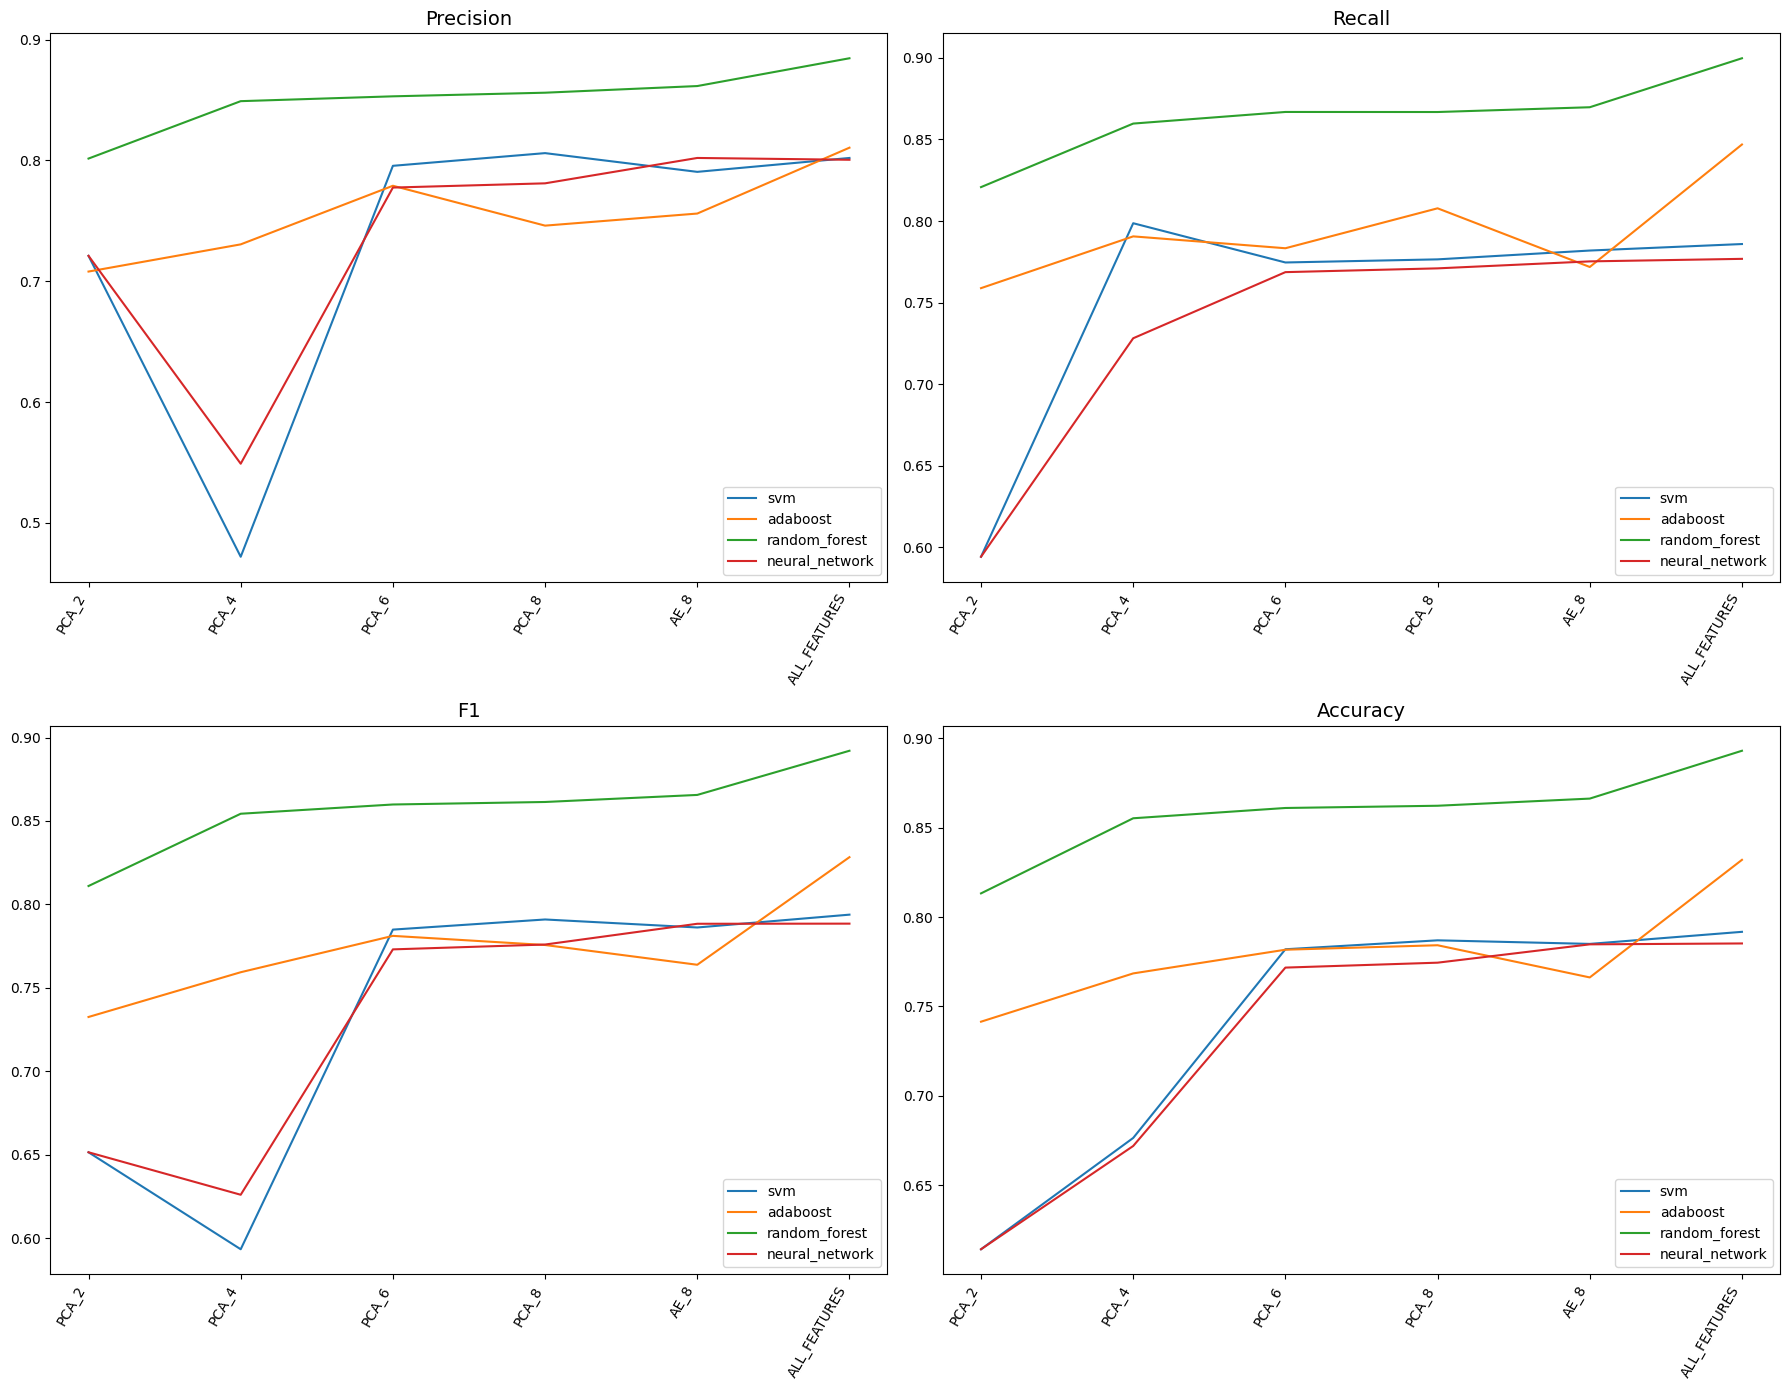

In [137]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
values = [scores_svm.values(), scores_ada.values(), scores_rf.values(), scores_nn.values()]
models = ['svm', 'adaboost', 'random_forest', 'neural_network']
x_labels = ['', 'PCA_2', 'PCA_4', 'PCA_6', 'PCA_8', 'AE_8', 'ALL_FEATURES']
for i in range(len(models)):
    ax1.plot([i['prec'] for i in values[i]], label=models[i])
    ax2.plot([i['rec'] for i in values[i]], label=models[i])
    ax3.plot([i['f1'] for i in values[i]], label=models[i])
    ax4.plot([i['acc'] for i in values[i]], label=models[i])
ax1.set_title('Precision', fontsize = 14)
ax2.set_title('Recall', fontsize = 14)
ax3.set_title('F1', fontsize = 14)
ax4.set_title('Accuracy', fontsize = 14)
ax1.set_xticklabels(x_labels, rotation = 60, ha="right")
ax2.set_xticklabels(x_labels, rotation = 60, ha="right")
ax3.set_xticklabels(x_labels, rotation = 60, ha="right")
ax4.set_xticklabels(x_labels, rotation = 60, ha="right")
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax3.legend(loc='lower right')
ax4.legend(loc='lower right')

plt.tight_layout()
plt.show()

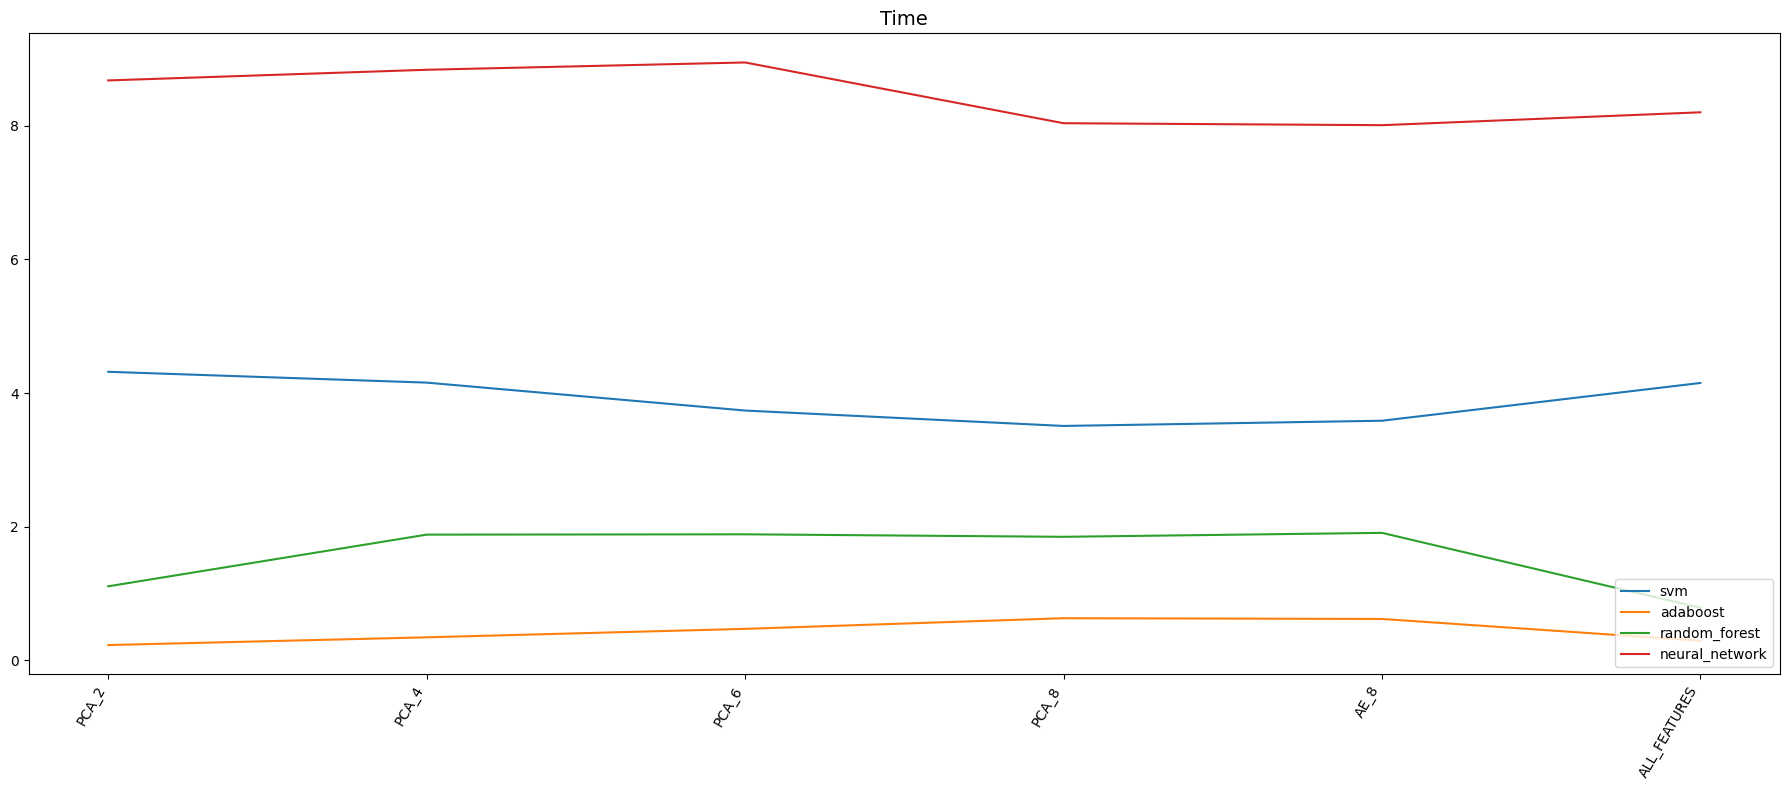

In [138]:
fig, ax1 = plt.subplots(1, 1, figsize=(18, 8))
for i in range(len(models)):
    ax1.plot([i['time'] for i in values[i]], label=models[i])
ax1.set_title('Time', fontsize = 14)
ax1.set_xticklabels(x_labels, rotation = 60, ha="right")
ax1.legend(loc='lower right')

plt.tight_layout()
plt.show()

## **2) Hyperparameters tuning**

In [154]:
# Computes the increase/decrese between two values in percentage points
def gain_percent(base, best):
    return ((best - base) * 100 / base)

### SVM

In [141]:
# CHOOSING THE BEST KERNEL
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
print(''.join(['> ' for i in range(50)]))
print(f'\n{"KERNEL":<15}{"PRECISION":>15}{"RECALL":>15}{"F1":>15}{"ACCURACY":>15}{"EXEC. TIME":>15}\n')
print(''.join(['> ' for i in range(50)]))
for k in kernels:
    X_train, X_test, y_train, y_test = get_data_split(X, y)
    start_time = time.time()
    svc = SVC(kernel=k)
    svc.fit(X_train, y_train)
    pred = svc.predict(X_test)
    end_time = time.time()
    print(f'\n{k.upper():<15}{precision_score(pred, y_test):>15.3f}{recall_score(pred, y_test):>15.3f}{f1_score(pred, y_test):>15.3f}{accuracy_score(pred, y_test):>15.3f}{end_time-start_time:>15.2f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

KERNEL               PRECISION         RECALL             F1       ACCURACY     EXEC. TIME

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

LINEAR                   0.706          0.824          0.760          0.777           2.79

POLY                     0.911          0.645          0.756          0.705           3.17

RBF                      0.802          0.786          0.794          0.792           4.12

SIGMOID                  0.621          0.628          0.624          0.626           4.30


In [156]:
# CHOOSING THE BEST HYPERPARAMETERS
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000, 5000], 
              'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001]}

print(''.join(['> ' for i in range(40)]))
print(f'\n{"HYPERPARAMETER":<25}{"RANGE_VALUES":<18}\n')
print(''.join(['> ' for i in range(40)]))
for k, v in param_grid_svm.items():
    print(f'\n{k:<25}{str(v):<18}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

HYPERPARAMETER           RANGE_VALUES      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

C                        [0.1, 1, 10, 100, 1000, 5000]

gamma                    [10, 1, 0.1, 0.01, 0.001, 0.0001]


In [160]:
X_train, X_test, y_train, y_test = get_data_split(X, y)
svc = SVC(kernel='rbf')
grid_search_svm = GridSearchCV(estimator = svc, param_grid = param_grid_svm,
                          cv = 5, n_jobs = -1, verbose = 1)
grid_search_svm.fit(X_train, y_train.ravel())
print(grid_search_svm.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'C': 5000, 'gamma': 10}


In [161]:
X_train, X_test, y_train, y_test = get_data_split(X, y)
metrics = {'BASE':{}, 'BEST':{}}
metrics_lab = ['precision', 'recall', 'f1', 'accuracy', 'exec_time']
start_time = time.time()
base_model = SVC(kernel='rbf')
base_model.fit(X_train, y_train)
base_pred = base_model.predict(X_test)
end_time = time.time()
metrics['BASE']['precision'] = precision_score(base_pred, y_test)
metrics['BASE']['recall'] = recall_score(base_pred, y_test)
metrics['BASE']['f1'] = f1_score(base_pred, y_test)
metrics['BASE']['accuracy'] = accuracy_score(base_pred, y_test)
metrics['BASE']['exec_time'] = end_time - start_time

best_model = grid_search_svm.best_estimator_
start_time = time.time()
best_model.fit(X_train, y_train)
best_pred = best_model.predict(X_test)
end_time = time.time()
metrics['BEST']['precision'] = precision_score(best_pred, y_test)
metrics['BEST']['recall'] = recall_score(best_pred, y_test)
metrics['BEST']['f1'] = f1_score(best_pred, y_test)
metrics['BEST']['accuracy'] = accuracy_score(best_pred, y_test)
metrics['BEST']['exec_time'] = end_time - start_time

print(''.join(['> ' for i in range(40)]))
print(f'\n{"METRIC":<25}{"BASE_MODEL":>18}{"BEST_MODEL":>18}{"GAIN (%)":>18}\n')
print(''.join(['> ' for i in range(40)]))
for i in metrics_lab:
    print(f'\n{i.upper():<25}{metrics["BASE"][i]:>18.3f}{metrics["BEST"][i]:>18.3f}{gain_percent(metrics["BASE"][i], metrics["BEST"][i]):>18.2f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

METRIC                           BASE_MODEL        BEST_MODEL          GAIN (%)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

PRECISION                             0.802             0.848              5.74

RECALL                                0.786             0.874             11.24

F1                                    0.794             0.861              8.45

ACCURACY                              0.792             0.863              9.00

EXEC_TIME                             4.294            46.918            992.63


### ADABoost

In [163]:
# CHOOSING THE BEST HYPERPARAMETERS
param_grid_ada = {'n_estimators': [10, 50, 100, 500, 1000], 
              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]}

print(''.join(['> ' for i in range(40)]))
print(f'\n{"HYPERPARAMETER":<25}{"RANGE_VALUES":<18}\n')
print(''.join(['> ' for i in range(40)]))
for k, v in param_grid_ada.items():
    print(f'\n{k:<25}{str(v):<18}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

HYPERPARAMETER           RANGE_VALUES      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

n_estimators             [10, 50, 100, 500, 1000]

learning_rate            [0.0001, 0.001, 0.01, 0.1, 1.0]


In [164]:
X_train, X_test, y_train, y_test = get_data_split(X, y)
adaboost = AdaBoostClassifier(random_state=3)
grid_search_ada = GridSearchCV(estimator = adaboost, param_grid = param_grid_ada,
                          cv = 5, n_jobs = -1, verbose = 1)
grid_search_ada.fit(X_train, y_train.ravel())
print(grid_search_ada.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'learning_rate': 1.0, 'n_estimators': 500}


In [165]:
X_train, X_test, y_train, y_test = get_data_split(X, y)
metrics = {'BASE':{}, 'BEST':{}}
metrics_lab = ['precision', 'recall', 'f1', 'accuracy', 'exec_time']
start_time = time.time()
base_model = AdaBoostClassifier(random_state=3)
base_model.fit(X_train, y_train)
base_pred = base_model.predict(X_test)
end_time = time.time()
metrics['BASE']['precision'] = precision_score(base_pred, y_test)
metrics['BASE']['recall'] = recall_score(base_pred, y_test)
metrics['BASE']['f1'] = f1_score(base_pred, y_test)
metrics['BASE']['accuracy'] = accuracy_score(base_pred, y_test)
metrics['BASE']['exec_time'] = end_time - start_time

best_model = grid_search_ada.best_estimator_
start_time = time.time()
best_model.fit(X_train, y_train)
best_pred = best_model.predict(X_test)
end_time = time.time()
metrics['BEST']['precision'] = precision_score(best_pred, y_test)
metrics['BEST']['recall'] = recall_score(best_pred, y_test)
metrics['BEST']['f1'] = f1_score(best_pred, y_test)
metrics['BEST']['accuracy'] = accuracy_score(best_pred, y_test)
metrics['BEST']['exec_time'] = end_time - start_time

print(''.join(['> ' for i in range(40)]))
print(f'\n{"METRIC":<25}{"BASE_MODEL":>18}{"BEST_MODEL":>18}{"GAIN (%)":>18}\n')
print(''.join(['> ' for i in range(40)]))
for i in metrics_lab:
    print(f'\n{i.upper():<25}{metrics["BASE"][i]:>18.3f}{metrics["BEST"][i]:>18.3f}{gain_percent(metrics["BASE"][i], metrics["BEST"][i]):>18.2f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

METRIC                           BASE_MODEL        BEST_MODEL          GAIN (%)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

PRECISION                             0.810             0.810              0.00

RECALL                                0.847             0.850              0.42

F1                                    0.828             0.830              0.20

ACCURACY                              0.832             0.834              0.24

EXEC_TIME                             0.296             2.864            867.16


### Random Forest

In [167]:
# CHOOSING THE BEST CRITERION
criterions = ['gini', 'entropy', 'log_loss']
print(''.join(['> ' for i in range(50)]))
print(f'\n{"CRITERION":<15}{"PRECISION":>15}{"RECALL":>15}{"F1":>15}{"ACCURACY":>15}{"EXEC. TIME":>15}\n')
print(''.join(['> ' for i in range(50)]))
for c in criterions:
    X_train, X_test, y_train, y_test = get_data_split(X, y)
    start_time = time.time()
    rf =RandomForestClassifier(criterion=c, random_state=3)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    end_time = time.time()
    print(f'\n{c.upper():<15}{precision_score(pred, y_test):>15.3f}{recall_score(pred, y_test):>15.3f}{f1_score(pred, y_test):>15.3f}{accuracy_score(pred, y_test):>15.3f}{end_time-start_time:>15.2f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

CRITERION            PRECISION         RECALL             F1       ACCURACY     EXEC. TIME

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

GINI                     0.884          0.900          0.892          0.893           0.94

ENTROPY                  0.888          0.900          0.894          0.894           0.82

LOG_LOSS                 0.888          0.900          0.894          0.894           0.81


In [171]:
# CHOOSING THE BEST HYPERPARAMETERS
param_grid_rf = {
    'n_estimators': [100, 500, 1000, 3000],   # number of trees in the foreset
    'max_depth': [10, 100, 200, None],        # max number of levels in each decision tree
    'min_samples_split': [2, 10, 20],         # min number of data points placed in a node before the node is split
    'min_samples_leaf': [1, 5],               # min number of data points allowed in a leaf node
    'bootstrap': [True, False]                # method for sampling data points (with or without replacement)
}

print(''.join(['> ' for i in range(40)]))
print(f'\n{"HYPERPARAMETER":<25}{"RANGE_VALUES":<18}\n')
print(''.join(['> ' for i in range(40)]))
for k, v in param_grid_rf.items():
    print(f'\n{k:<25}{str(v):<18}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

HYPERPARAMETER           RANGE_VALUES      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

n_estimators             [100, 500, 1000, 3000]

max_depth                [10, 100, 200, None]

min_samples_split        [2, 10, 20]       

min_samples_leaf         [1, 5]            

bootstrap                [True, False]     


In [172]:
X_train, X_test, y_train, y_test = get_data_split(X, y)
rf = RandomForestClassifier(random_state=3)
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid_rf,
                          cv = 5, n_jobs = -1, verbose = 1)
grid_search_rf.fit(X_train, y_train.ravel())
print(grid_search_rf.best_params_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
{'bootstrap': False, 'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 3000}


In [173]:
X_train, X_test, y_train, y_test = get_data_split(X, y)
metrics = {'BASE':{}, 'BEST':{}}
metrics_lab = ['precision', 'recall', 'f1', 'accuracy', 'exec_time']
start_time = time.time()
base_model = RandomForestClassifier(random_state=3)
base_model.fit(X_train, y_train)
base_pred = base_model.predict(X_test)
end_time = time.time()
metrics['BASE']['precision'] = precision_score(base_pred, y_test)
metrics['BASE']['recall'] = recall_score(base_pred, y_test)
metrics['BASE']['f1'] = f1_score(base_pred, y_test)
metrics['BASE']['accuracy'] = accuracy_score(base_pred, y_test)
metrics['BASE']['exec_time'] = end_time - start_time

best_model = grid_search_rf.best_estimator_
start_time = time.time()
best_model.fit(X_train, y_train)
best_pred = best_model.predict(X_test)
end_time = time.time()
metrics['BEST']['precision'] = precision_score(best_pred, y_test)
metrics['BEST']['recall'] = recall_score(best_pred, y_test)
metrics['BEST']['f1'] = f1_score(best_pred, y_test)
metrics['BEST']['accuracy'] = accuracy_score(best_pred, y_test)
metrics['BEST']['exec_time'] = end_time - start_time

print(''.join(['> ' for i in range(40)]))
print(f'\n{"METRIC":<25}{"BASE_MODEL":>18}{"BEST_MODEL":>18}{"GAIN (%)":>18}\n')
print(''.join(['> ' for i in range(40)]))
for i in metrics_lab:
    print(f'\n{i.upper():<25}{metrics["BASE"][i]:>18.3f}{metrics["BEST"][i]:>18.3f}{gain_percent(metrics["BASE"][i], metrics["BEST"][i]):>18.2f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

METRIC                           BASE_MODEL        BEST_MODEL          GAIN (%)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

PRECISION                             0.884             0.888              0.45

RECALL                                0.900             0.904              0.45

F1                                    0.892             0.896              0.45

ACCURACY                              0.893             0.897              0.45

EXEC_TIME                             0.770            31.821           4032.03


### Neural Network